In [19]:
# === QB draft audit & patch (Jupyter edition) ===
# Works with the files your script wrote:
#   qb_primary_starters_1999_2024.csv
#   qb_playoff_first_starters_1999_2024.csv
#   qb_super_bowl_starters_1999_2024.csv

import pandas as pd
import numpy as np
from pathlib import Path

REG_PATH = "qb_primary_starters_2000_2024.csv"
PO_PATH  = "qb_playoff_first_starters_2000_2024.csv"
SB_PATH  = "qb_super_bowl_starters_2000_2024.csv"
FILL_CSV = "manual_qb_draft_fills.csv"

# Franchise canonizer (handles legacy codes)
FRANCHISE_CANON = {
    "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
    "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
    "LAC":"LAC","LAR":"LAR","LV":"LV","MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO",
    "NYG":"NYG","NYJ":"NYJ","PHI":"PHI","PIT":"PIT","SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN","WAS":"WAS",
    # legacy / alternates
    "OAK":"LV","RAI":"LV","SD":"LAC","SDG":"LAC","STL":"LAR","LA":"LAR","PHO":"ARI","WSH":"WAS",
    "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
}
def canon(team):
    if pd.isna(team): return np.nan
    t = str(team).strip().upper()
    return FRANCHISE_CANON.get(t, t)

def _load_all():
    reg = pd.read_csv(REG_PATH)
    po  = pd.read_csv(PO_PATH)
    sb  = pd.read_csv(SB_PATH)
    return reg, po, sb

def prepare_missing(write_csv=True):
    """
    Scan all three files for rows with draft_team NaN and write a fill template CSV you can edit.
    Returns the DataFrame of missing players.
    """
    reg, po, sb = _load_all()

    def missing(df):
        cols = ["qb_name"]
        if "player_norm" in df.columns: cols = ["player_norm"]
        out = df[df["draft_team"].isna()][cols].drop_duplicates()
        return out.rename(columns={cols[0]: "player_norm"})

    miss = pd.concat([missing(reg), missing(po), missing(sb)], ignore_index=True)
    miss = miss.drop_duplicates().sort_values("player_norm").reset_index(drop=True)

    if miss.empty:
        print("🎉 No missing draft entries found.")
        return miss

    # Start a fill table (preserve previous entries if the file existed)
    miss["draft_team"]   = ""
    miss["draft_season"] = ""

    if Path(FILL_CSV).exists():
        prev = pd.read_csv(FILL_CSV)
        prev = prev[["player_norm","draft_team","draft_season"]]
        miss = miss.merge(prev, on="player_norm", how="left", suffixes=("_new",""))
        for col in ["draft_team","draft_season"]:
            miss[col] = miss[col].where(miss[col].notna() & (miss[col] != ""), miss[f"{col}_new"])
        miss = miss[["player_norm","draft_team","draft_season"]]

    if write_csv:
        miss.to_csv(FILL_CSV, index=False)
        print(f"📝 Wrote {len(miss)} players to {FILL_CSV}")
        print('→ Fill "draft_team" with a 2–3 letter code (e.g., IND, NE, SD, STL, OAK) or "UND" for undrafted;')
        print('  and "draft_season" with the draft year (e.g., 1998).')

    return miss

# (Optional) prefill some common pre-1999 / undrafted QBs so you type less.
# Keep only what you’re sure about; delete or edit freely.
PREFILL = {
    # drafted pre-1999
    "P.Manning": ("IND", 1998),
    "B.Favre":   ("ATL", 1991),  # drafted by ATL; traded to GB
    "D.Bledsoe": ("NE", 1993),
    "T.Aikman":  ("DAL", 1989),
    "S.McNair":  ("HOU", 1995),  # Oilers → TEN
    "K.Collins": ("CAR", 1995),
    "E.Grbac":   ("SF",  1993),
    "T.Dilfer":  ("TB",  1994),
    "C.Chandler":("IND", 1988),
    "K.Stewart": ("PIT", 1995),
    "J.Kitna":   ("SEA", 1996),  # actually UDFA signed by SEA in 1996; if you prefer, set "UND"
    "B.Johnson": ("MIN", 1992),
    "M.Brunell": ("GB",  1993),
    "J.Fiedler": ("UND", 1994),
    "J.Garcia":  ("UND", 1994),
    "J.Delhomme":("UND", 1997),
    "K.Warner":  ("UND", 1994),
    "T.Romo":    ("UND", 2003),  # 2003 UDFA DAL (post-1999 but handy)
    # You can add more as you encounter them…
}

def apply_prefill_to_fill_csv(prefill=PREFILL):
    """
    Write or update manual_qb_draft_fills.csv using PREFILL dict for quick starts.
    Only fills rows that currently have blank draft_team/draft_season.
    """
    miss = prepare_missing(write_csv=True)  # ensures the file exists & is current
    if miss.empty:
        print("No missing rows to prefill.")
        return miss

    df = pd.read_csv(FILL_CSV)
    df = df.drop_duplicates(subset=["player_norm"]).copy()

    # apply where empty
    for k, (team, year) in prefill.items():
        mask = df["player_norm"].eq(k) & ((df["draft_team"]=="") | (df["draft_team"].isna()))
        if mask.any():
            df.loc[mask, "draft_team"]   = team
            df.loc[mask, "draft_season"] = year

    df.to_csv(FILL_CSV, index=False)
    print(f"✅ Prefilled {sum(df['player_norm'].isin(prefill.keys()))} known names (where blank).")
    return df

def apply_fills_and_recompute():
    """
    Read manual_qb_draft_fills.csv, patch the 3 CSVs, recompute drafted_by_team,
    and report any remaining NaNs.
    """
    reg, po, sb = _load_all()
    fills = pd.read_csv(FILL_CSV) if Path(FILL_CSV).exists() else pd.DataFrame(columns=["player_norm","draft_team","draft_season"])

    # normalize fill table
    fills["draft_team"]   = fills["draft_team"].replace("", np.nan)
    fills["draft_season"] = pd.to_numeric(fills["draft_season"], errors="coerce")
    # UND should count as "not drafted-by-team" → keep draft_team as NaN for equality check
    fills["draft_team_canon"] = fills["draft_team"].map(lambda x: np.nan if (pd.isna(x) or str(x).upper()=="UND") else canon(x))

    def _patch(df):
        df = df.copy()
        if "player_norm" not in df.columns:
            df["player_norm"] = df["qb_name"]
        df = df.merge(fills[["player_norm","draft_team_canon","draft_season"]],
                      on="player_norm", how="left")
        # fill only where original draft_team is NaN and we have a fill
        need = df["draft_team"].isna() & df["draft_team_canon"].notna()
        df.loc[need, "draft_team"]   = df.loc[need, "draft_team_canon"]
        df.loc[need, "draft_season"] = df.loc[need, "draft_season"]

        # recompute flag
        df["team_canon"] = df["team"].map(canon)
        df["draft_team"] = df["draft_team"].map(canon)
        df["drafted_by_team"] = df["team_canon"].eq(df["draft_team"]).fillna(False)
        return df.drop(columns=["draft_team_canon"], errors="ignore")

    reg_m = _patch(reg); po_m = _patch(po); sb_m = _patch(sb)
    reg_m.to_csv(REG_PATH, index=False)
    po_m.to_csv(PO_PATH,  index=False)
    sb_m.to_csv(SB_PATH,  index=False)

    def _report(df, label):
        miss = df[df["draft_team"].isna()][["season","team","qb_name"]].sort_values(["season","team"])
        if miss.empty:
            print(f"✅ {label}: no missing draft entries")
        else:
            print(f"⚠️  {label}: {len(miss)} still missing — add these to {FILL_CSV}")
            display(miss.head(30))

    _report(reg_m, "Regular season")
    _report(po_m,  "Playoffs")
    _report(sb_m,  "Super Bowl")

    return reg_m, po_m, sb_m

def quick_shares(reg_df):
    """
    Quick per-season % drafted-by-team so you can see fixes move the early-2000s.
    """
    out = (reg_df.groupby("season")["drafted_by_team"]
                 .mean().mul(100).round(1).reset_index(name="Regular-season % drafted"))
    display(out.head(10))
    display(out.tail(10))
    return out


In [20]:
# === Recompute drafted-by-team shares (ignoring unknowns) — FIXED ===
import pandas as pd
import numpy as np

# ---- paths (edit if yours differ) ----
REG_PATH = "qb_primary_starters_2000_2024.csv"
PO_PATH  = "qb_playoff_first_starters_2000_2024.csv"
SB_PATH  = "qb_super_bowl_starters_2000_2024.csv"
FILLS    = "manual_qb_draft_fills.csv"

# ---- franchise canon (maps legacy to current) ----
FRANCHISE_CANON = {
    "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
    "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
    "LAC":"LAC","LAR":"LAR","LV":"LV","MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO",
    "NYG":"NYG","NYJ":"NYJ","PHI":"PHI","PIT":"PIT","SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN","WAS":"WAS",
    # legacy/alternates
    "OAK":"LV","RAI":"LV","SD":"LAC","SDG":"LAC","STL":"LAR","LA":"LAR","PHO":"ARI","WSH":"WAS",
    "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
}
def canon(team):
    if pd.isna(team): return np.nan
    t = str(team).strip().upper()
    return FRANCHISE_CANON.get(t, t)

# ---- minor name normalization fixes ----
NAME_FIXES = {
    "As.Rodgers": "A.Rodgers",
    "Alex Smith": "A.Smith",
}

def normalize_qb_names(df):
    df = df.copy()
    df["qb_name"] = df["qb_name"].replace(NAME_FIXES)
    df["player_norm"] = df["qb_name"]
    return df

# ---- load inputs ----
reg = pd.read_csv(REG_PATH)
po  = pd.read_csv(PO_PATH)
sb  = pd.read_csv(SB_PATH)
fills = pd.read_csv(FILLS)

# Treat UND as unknown so it never counts as drafted-by-team
fills["draft_team"]   = fills["draft_team"].replace("", np.nan)
fills["draft_season"] = pd.to_numeric(fills["draft_season"], errors="coerce")
fills["fill_draft_team"]   = fills["draft_team"].map(lambda x: np.nan if (pd.isna(x) or str(x).upper()=="UND") else canon(x))
fills["fill_draft_season"] = fills["draft_season"]

reg = normalize_qb_names(reg)
po  = normalize_qb_names(po)
sb  = normalize_qb_names(sb)

def apply_fills(df):
    df = df.copy()
    # ensure target columns exist
    if "draft_team" not in df.columns:
        df["draft_team"] = np.nan
    if "draft_season" not in df.columns:
        df["draft_season"] = np.nan

    # merge fills with distinct column names
    df = df.merge(
        fills[["player_norm","fill_draft_team","fill_draft_season"]],
        on="player_norm", how="left"
    )

    # overlay where missing
    need = df["draft_team"].isna() & df["fill_draft_team"].notna()
    df.loc[need, "draft_team"]   = df.loc[need, "fill_draft_team"]
    df.loc[need, "draft_season"] = df.loc[need, "fill_draft_season"]

    # recompute flag
    df["team_canon"] = df["team"].map(canon)
    df["draft_team"] = df["draft_team"].map(canon)
    df["drafted_by_team"] = df["team_canon"].eq(df["draft_team"])

    return df.drop(columns=["fill_draft_team","fill_draft_season"], errors="ignore")

reg_m = apply_fills(reg)
po_m  = apply_fills(po)
sb_m  = apply_fills(sb)

# ---- compute shares, IGNORING unknowns (draft_team is NaN) ----
def pct_drafted(df):
    known = df[df["draft_team"].notna()]
    if known.empty: return np.nan, 0
    return 100.0 * known["drafted_by_team"].mean(), len(known)

overall_reg, n_reg = pct_drafted(reg_m)
overall_po,  n_po  = pct_drafted(po_m)
overall_sb,  n_sb  = pct_drafted(sb_m)

print("=== Headline (ignoring unknowns) ===")
print(f"Regular-season primary starters: {overall_reg:.1f}%  (n={n_reg})")
print(f"Playoff first-game starters:     {overall_po:.1f}%  (n={n_po})")
print(f"Super Bowl starters:             {overall_sb:.1f}%  (n={n_sb})")

# ---- per-season (ignoring unknowns) ----
def per_season_pct(df, label):
    d = df[df["draft_team"].notna()].copy()
    return (d.groupby("season")["drafted_by_team"]
              .mean().mul(100).round(1)
              .reset_index(name=f"{label} % drafted"))

reg_season = per_season_pct(reg_m, "Regular-season")
po_season  = per_season_pct(po_m,  "Playoff")
sb_season  = per_season_pct(sb_m,  "Super Bowl")

per_season = (reg_season.merge(po_season, on="season", how="outer")
                        .merge(sb_season, on="season", how="outer")
                        .sort_values("season").reset_index(drop=True))

print("\n=== Per-season shares (ignoring unknowns) ===")
display(per_season.head(10)); display(per_season.tail(10))

# ---- era breakdowns (ignoring unknowns) ----
def era_from_season(season: int) -> str:
    if 2000 <= season <= 2009: return "2000s"
    if 2010 <= season <= 2019: return "2010s"
    if 2020 <= season <= 2029: return "2020s"
    return "Other"

def era_table(df, label):
    d = df[df["draft_team"].notna()].copy()
    if d.empty:
        return pd.DataFrame(columns=["era", f"{label} % drafted-by-team"])
    d["era"] = d["season"].map(era_from_season)
    return (d.groupby("era")["drafted_by_team"]
              .mean().mul(100).round(1)
              .rename(f"{label} % drafted-by-team")
              .reset_index())

era_out = (era_table(reg_m, "Regular-season primary starters")
           .merge(era_table(po_m, "Playoff first-game starters"), on="era", how="outer")
           .merge(era_table(sb_m, "Super Bowl starters"),        on="era", how="outer")
           .sort_values("era"))

print("\n=== Era breakdown (ignoring unknowns) ===")
display(era_out)

# ---- save refreshed files + summaries ----
reg_m.to_csv(REG_PATH, index=False)
po_m.to_csv(PO_PATH,  index=False)
sb_m.to_csv(SB_PATH,  index=False)
per_season.to_csv("qb_drafted_share_per_season_ignoring_unknowns.csv", index=False)
era_out.to_csv("qb_drafted_share_by_era_ignoring_unknowns.csv", index=False)

print("\nSaved:")
print(" -", REG_PATH)
print(" -", PO_PATH)
print(" -", SB_PATH)
print(" - qb_drafted_share_per_season_ignoring_unknowns.csv")
print(" - qb_drafted_share_by_era_ignoring_unknowns.csv")


=== Headline (ignoring unknowns) ===
Regular-season primary starters: 61.0%  (n=688)
Playoff first-game starters:     66.8%  (n=274)
Super Bowl starters:             73.9%  (n=46)

=== Per-season shares (ignoring unknowns) ===


,season,Regular-season % drafted,Playoff % drafted,Super Bowl % drafted
0,2000,47.6,55.6,0.0
1,2001,55.6,33.3,100.0
2,2002,54.5,62.5,0.0
3,2003,45.0,44.4,100.0
4,2004,57.1,66.7,100.0
5,2005,55.2,60.0,50.0
6,2006,59.3,40.0,100.0
7,2007,57.7,55.6,50.0
8,2008,57.7,60.0,100.0
9,2009,62.1,70.0,50.0


,season,Regular-season % drafted,Playoff % drafted,Super Bowl % drafted
15,2015,56.7,72.7,50.0
16,2016,63.3,72.7,100.0
17,2017,71.0,72.7,100.0
18,2018,82.8,83.3,100.0
19,2019,71.4,58.3,50.0
20,2020,69.0,69.2,50.0
21,2021,70.0,71.4,50.0
22,2022,58.1,76.9,100.0
23,2023,64.5,71.4,100.0
24,2024,67.7,64.3,100.0



=== Era breakdown (ignoring unknowns) ===


,era,Regular-season primary starters % drafted-by-team,Playoff first-game starters % drafted-by-team,Super Bowl starters % drafted-by-team
0,2000s,55.7,55.9,62.5
1,2010s,63.1,73.5,80.0
2,2020s,65.8,70.6,80.0



Saved:
 - qb_primary_starters_2000_2024.csv
 - qb_playoff_first_starters_2000_2024.csv
 - qb_super_bowl_starters_2000_2024.csv
 - qb_drafted_share_per_season_ignoring_unknowns.csv
 - qb_drafted_share_by_era_ignoring_unknowns.csv


In [21]:
# --- add under your imports ---
DATA_SOURCE = "Datafrom NFLFastR"

def annotate_source(ax, text=DATA_SOURCE):
    # bottom-right in axes coords
    ax.text(
        0.995, -0.1, text,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9, alpha=0.7
    )


drafted_by_team,season,acquired_count,drafted_count,total_known,share_drafted
0,2000,11,10,21,47.6
1,2001,8,10,18,55.6
2,2002,10,12,22,54.5
3,2003,11,9,20,45.0
4,2004,12,16,28,57.1
5,2005,13,16,29,55.2
6,2006,11,16,27,59.3
7,2007,11,15,26,57.7
8,2008,11,15,26,57.7
9,2009,11,18,29,62.1


drafted_by_team,season,acquired_count,drafted_count,total_known,share_drafted
13,2013,11,17,28,60.7
14,2014,12,16,28,57.1
15,2015,13,17,30,56.7
16,2016,11,19,30,63.3
17,2017,9,22,31,71.0
18,2018,5,24,29,82.8
19,2019,8,20,28,71.4
20,2020,9,20,29,69.0
21,2021,9,21,30,70.0
22,2022,13,18,31,58.1


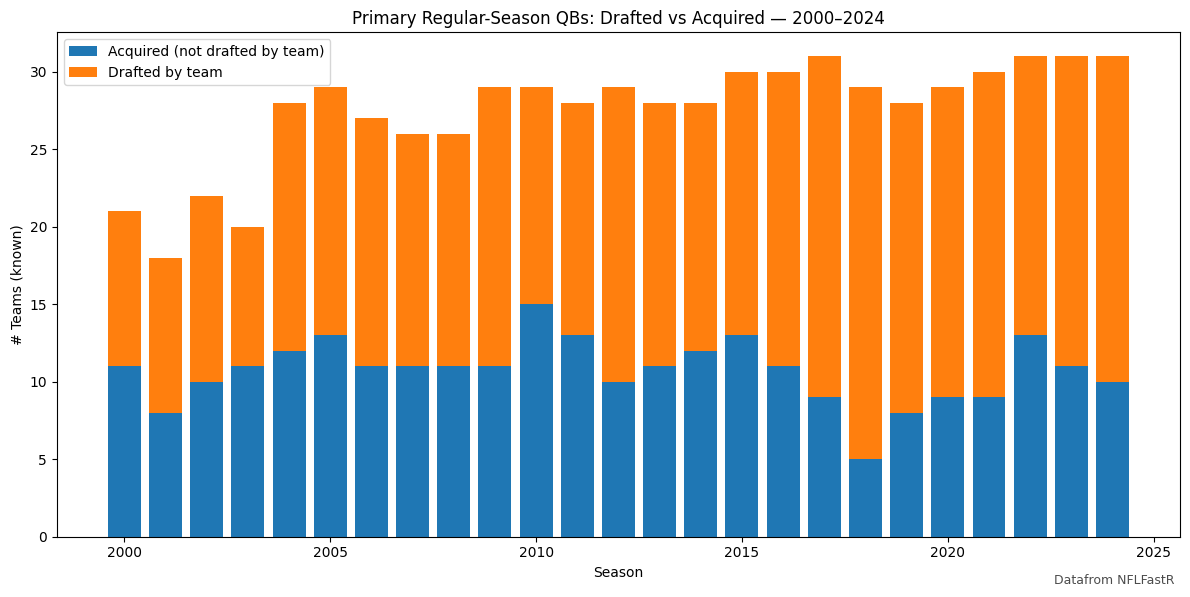

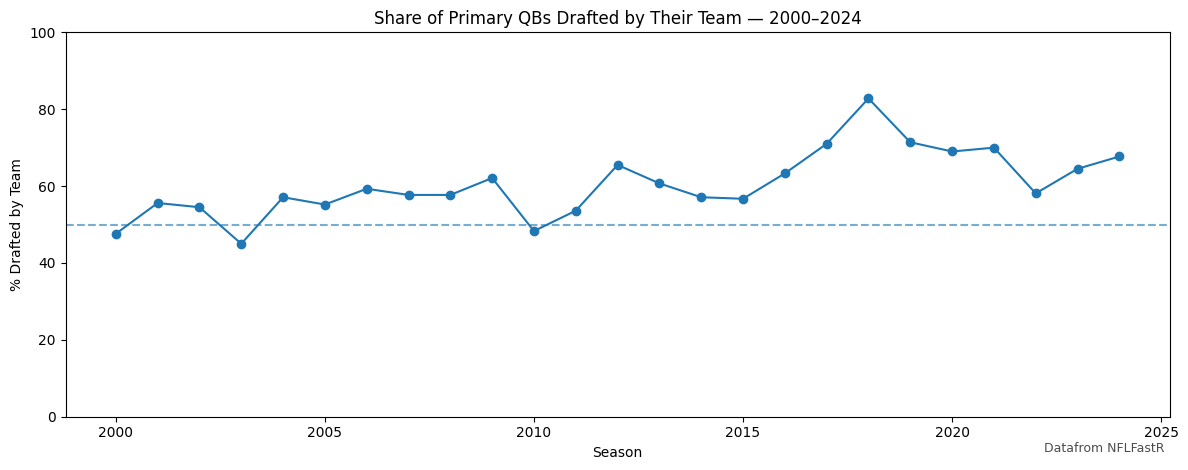

=== Season-level success rates (TEAM-SEASON denominator) ===


,QB Origin,playoff_rate,playoff_ci_low,playoff_ci_high,sb_rate,sb_ci_low,sb_ci_high
0,Acquired (FA/Trade),34.3,28.9,40.2,4.5,2.6,7.7
1,Drafted by Team,44.8,40.1,49.5,8.1,5.9,11.1


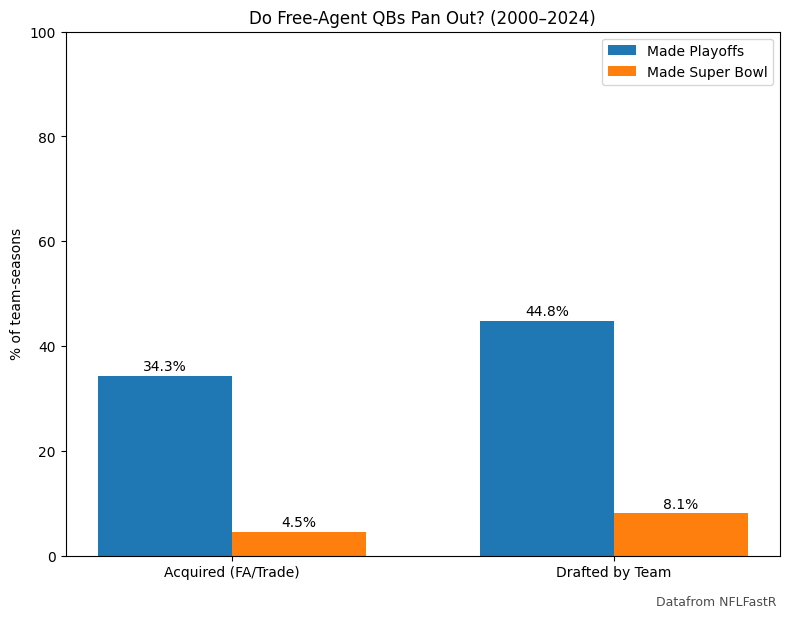


Sanity checks:
Denominator by origin (team-seasons):
drafted_by_team
Acquired    268
Drafted     420
dtype: int64
Distinct playoff team-seasons: 310 | distinct SB team-seasons: 50

=== QB-centric tenure (consecutive seasons as primary) ===


C:\Users\PC\AppData\Local\Temp\ipykernel_38376\3132402853.py:251: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = r.groupby(["team_canon","qb_name"], group_keys=False).apply(add_consecutive_tenure)


,mean,median,max,N
drafted_by_team,,,,
Acquired,2.97,2.0,15,268
Drafted,3.30,2.0,15,420


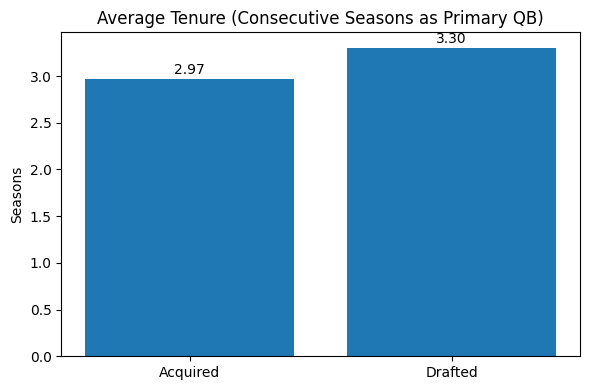

In [22]:
# ============================================================
# "Do free-agent QBs pan out?" — fully consistent build
# ============================================================
# Requirements: pandas, numpy, matplotlib
# Notes:
# - Rates use a TEAM-SEASON denominator (ONE row per (season, team_canon))
# - Membership (playoffs/SB) uses FULL playoff/SB tables (no draft filtering)
# - Franchise codes are canonized everywhere (SD->LAC, STL->LAR, OAK/WSH->LV/WAS, etc.)
# - Tenure is QB-centric (how many consecutive seasons a given QB is primary)
# - Toggle saving tables/figures via SAVE_* flags
# ============================================================

import os
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------- KNOBS ---------------------
REG_CANDS = ["qb_primary_starters_2000_2024.csv"]
PO_CANDS  = ["qb_playoff_first_starters_2000_2024.csv"]
SB_CANDS  = ["qb_super_bowl_starters_2000_2024.csv"]

SEASON_START = 2000     # inclusive
SEASON_END   = 2024     # inclusive

SAVE_TABLES = False
SAVE_FIGS   = False
OUT_DIR     = "out_qb_origin"
os.makedirs(OUT_DIR, exist_ok=True)

# Tie-breaks for picking ONE primary QB per team-season if multiple rows exist
TIEBREAK_CANDIDATES = [
    "games_started","starts","gs","games","n_games","team_games_started","primary_rank"
]

# ------------------ Franchise Canon ------------------
FRANCHISE_CANON = {
    "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
    "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
    "LAC":"LAC","LAR":"LAR","LV":"LV","MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO",
    "NYG":"NYG","NYJ":"NYJ","PHI":"PHI","PIT":"PIT","SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN","WAS":"WAS",
    # Legacy/alternates
    "OAK":"LV","RAI":"LV","SD":"LAC","SDG":"LAC","STL":"LAR","LA":"LAR","PHO":"ARI","WSH":"WAS",
    "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
}
def canon_team(x):
    if pd.isna(x): return np.nan
    s = str(x).upper()
    return FRANCHISE_CANON.get(s, s)

# ------------------ Loaders ------------------
def _load_first(name_in_mem, candidates):
    """Return a copy of an already-loaded global df if present; else read the first CSV found."""
    if name_in_mem in globals():
        return globals()[name_in_mem].copy()
    for p in candidates:
        try:
            return pd.read_csv(p)
        except FileNotFoundError:
            continue
    raise FileNotFoundError(f"Couldn’t find any of: {candidates}")

# ------------------ Core Helpers ------------------
def lock_window(df, start, end):
    return df.query("@start <= season <= @end").copy()

def add_canon_all(*dfs):
    for df in dfs:
        df["team_canon"] = df["team"].map(canon_team)

def membership_sets(po, sb):
    po_set = set(map(tuple, po[["season","team_canon"]].drop_duplicates().values))
    sb_set = set(map(tuple, sb[["season","team_canon"]].drop_duplicates().values))
    return po_set, sb_set

def collapse_to_team_season(reg_known):
    """Pick exactly one 'primary' row per (season, team_canon) using smart tie-breaks."""
    present = [c for c in TIEBREAK_CANDIDATES if c in reg_known.columns]

    sort_cols = ["season","team_canon"]
    asc = [True, True]
    for c in present:
        # counts DESC, rank ASC
        sort_cols.append(c)
        asc.append(c == "primary_rank")
    sort_cols.append("qb_name"); asc.append(True)   # deterministic final tie-break

    # keep='last' so higher counts (sorted last) are kept; for rank we sorted ascending
    den = (
        reg_known.sort_values(sort_cols, ascending=asc)
                 .drop_duplicates(subset=["season","team_canon"], keep="last")
                 [["season","team_canon","drafted_by_team"]]
                 .reset_index(drop=True)
    )
    return den

def wilson_ci(successes, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    p = successes / n
    denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    margin = (z * np.sqrt((p*(1-p)/n) + (z*z/(4*n*n)))) / denom
    return center - margin, center + margin

def rates_table(den):
    grp = den.groupby("drafted_by_team")[["made_playoffs","made_sb"]].agg(["sum","count"])
    grp.columns = ["_".join(c) for c in grp.columns]
    grp["playoff_rate"] = 100 * grp["made_playoffs_sum"] / grp["made_playoffs_count"]
    grp["sb_rate"]      = 100 * grp["made_sb_sum"]       / grp["made_sb_count"]

    grp["playoff_ci_low"], grp["playoff_ci_high"] = zip(*grp.apply(
        lambda r: wilson_ci(r["made_playoffs_sum"], r["made_playoffs_count"]), axis=1))
    grp["sb_ci_low"], grp["sb_ci_high"] = zip(*grp.apply(
        lambda r: wilson_ci(r["made_sb_sum"], r["made_sb_count"]), axis=1))
    grp[["playoff_ci_low","playoff_ci_high","sb_ci_low","sb_ci_high"]] *= 100

    out = (grp.reset_index()
              .replace({"drafted_by_team": {True:"Drafted by Team", False:"Acquired (FA/Trade)"}})
              [["drafted_by_team","playoff_rate","playoff_ci_low","playoff_ci_high","sb_rate","sb_ci_low","sb_ci_high"]]
              .rename(columns={"drafted_by_team":"QB Origin"})
              .round(1))
    return out

# ------------------ Plots ------------------
def plot_counts(ct, season_start, season_end, fname_prefix=None):
    plt.figure(figsize=(12,6))
    ax = plt.gca()
    plt.bar(ct.index, ct["acquired_count"], label="Acquired (not drafted by team)")
    plt.bar(ct.index, ct["drafted_count"], bottom=ct["acquired_count"], label="Drafted by team")
    plt.title(f"Primary Regular-Season QBs: Drafted vs Acquired — {season_start}–{season_end}")
    plt.xlabel("Season"); plt.ylabel("# Teams (known)")
    plt.legend(); plt.tight_layout()
    annotate_source(ax)
    if SAVE_FIGS and fname_prefix:
        plt.savefig(os.path.join(OUT_DIR, f"{fname_prefix}_counts_stacked.png"), dpi=200)
    plt.show()

    plt.figure(figsize=(12,4.8))
    ax = plt.gca()
    plt.plot(ct.index, ct["share_drafted"], marker="o")
    plt.axhline(50, linestyle="--", alpha=0.6)
    plt.ylim(0,100); plt.title(f"Share of Primary QBs Drafted by Their Team — {season_start}–{season_end}")
    plt.xlabel("Season"); plt.ylabel("% Drafted by Team")
    plt.tight_layout()
    annotate_source(ax)
    if SAVE_FIGS and fname_prefix:
        plt.savefig(os.path.join(OUT_DIR, f"{fname_prefix}_share_drafted.png"), dpi=200)
    plt.show()

def plot_rates(summary, season_start, season_end, fname_prefix=None):
    labels = summary["QB Origin"].values
    playoffs = summary["playoff_rate"].values
    superbowls = summary["sb_rate"].values
    x = np.arange(len(labels)); w = 0.35

    plt.figure(figsize=(8,6))
    ax = plt.gca()
    plt.bar(x - w/2, playoffs, width=w, label="Made Playoffs")
    plt.bar(x + w/2, superbowls, width=w, label="Made Super Bowl")
    plt.xticks(x, labels); plt.ylim(0,100); plt.ylabel("% of team-seasons")
    plt.title(f"Do Free-Agent QBs Pan Out? ({season_start}–{season_end})")
    plt.legend()
    for i, val in enumerate(playoffs):   plt.text(x[i]-w/2, val+1, f"{val:.1f}%", ha="center")
    for i, val in enumerate(superbowls): plt.text(x[i]+w/2, val+1, f"{val:.1f}%", ha="center")
    plt.tight_layout()
    annotate_source(ax)
    if SAVE_FIGS and fname_prefix:
        plt.savefig(os.path.join(OUT_DIR, f"{fname_prefix}_rates.png"), dpi=200)
    plt.show()

# ------------------ Main ------------------
def main():
    # Load
    reg = _load_first("reg_m", REG_CANDS)
    po  = _load_first("po_m",  PO_CANDS)
    sb  = _load_first("sb_m",  SB_CANDS)

    # Window
    reg = lock_window(reg, SEASON_START, SEASON_END)
    po  = lock_window(po,  SEASON_START, SEASON_END)
    sb  = lock_window(sb,  SEASON_START, SEASON_END)

    # Canon
    add_canon_all(reg, po, sb)

    # ============ Section 1: Drafted vs Acquired counts by season ============
    # Denominator for counts is "known draft team" entries (by design)
    reg_k = reg[reg["draft_team"].notna()].copy()

    counts = (reg_k.groupby(["season","drafted_by_team"])["team_canon"]
                   .nunique().rename("teams").reset_index())

    ct = counts.pivot(index="season", columns="drafted_by_team", values="teams").fillna(0)
    ct = ct.rename(columns={True:"drafted_count", False:"acquired_count"})
    ct["total_known"]   = ct["drafted_count"] + ct["acquired_count"]
    ct["share_drafted"] = (100 * ct["drafted_count"] / ct["total_known"]).round(1)

    display(ct.reset_index().head(12))
    display(ct.reset_index().tail(12))

    if SAVE_TABLES:
        ct.reset_index().to_csv(os.path.join(OUT_DIR, "counts_by_season.csv"), index=False)

    plot_counts(ct, SEASON_START, SEASON_END, fname_prefix="section1")

    # ============ Section 2: Playoff/SB rates (TEAM-SEASON denominator) ============
    # Build membership from FULL tables (no draft filtering)
    po_set, sb_set = membership_sets(po, sb)

    # Collapse to ONE row per (season, team_canon) among known-draft rows
    reg_known = reg[reg["draft_team"].notna()].copy()
    den = collapse_to_team_season(reg_known)

    # Flags
    den["made_playoffs"] = list(map(lambda x: x in po_set, map(tuple, den[["season","team_canon"]].values)))
    den["made_sb"]       = list(map(lambda x: x in sb_set, map(tuple, den[["season","team_canon"]].values)))

    # Rates table
    summary = rates_table(den)
    print("=== Season-level success rates (TEAM-SEASON denominator) ===")
    display(summary)

    if SAVE_TABLES:
        summary.to_csv(os.path.join(OUT_DIR, "rates_team_season.csv"), index=False)

    # Plot rates
    plot_rates(summary, SEASON_START, SEASON_END, fname_prefix="section2")

    # Sanity
    print("\nSanity checks:")
    print("Denominator by origin (team-seasons):")
    print(den.groupby("drafted_by_team").size().rename(index={True:'Drafted', False:'Acquired'}))
    print("Distinct playoff team-seasons:", len(po_set), "| distinct SB team-seasons:", len(sb_set))

    # ============ Section 3: QB-centric tenure (consecutive years as primary) ============
    # (QB-centric on purpose; uses reg_k as in your earlier intent)
    r = (reg_k[["season","team_canon","qb_name","drafted_by_team"]]
            .drop_duplicates()
            .sort_values(["team_canon","qb_name","season"])
            .reset_index(drop=True))

    def add_consecutive_tenure(df):
        seasons = df["season"].to_numpy()
        tenure = np.ones(len(seasons), dtype=int)
        for i in range(1, len(seasons)):
            tenure[i] = tenure[i-1] + 1 if seasons[i] == seasons[i-1] + 1 else 1
        df["tenure_so_far"] = tenure
        return df

    r = r.groupby(["team_canon","qb_name"], group_keys=False).apply(add_consecutive_tenure)
    tenure_summary = (r.groupby("drafted_by_team")["tenure_so_far"]
                        .agg(mean="mean", median="median", max="max", N="count")
                        .rename(index={True:"Drafted", False:"Acquired"})
                        .round(2))
    print("\n=== QB-centric tenure (consecutive seasons as primary) ===")
    display(tenure_summary)

    if SAVE_TABLES:
        tenure_summary.reset_index().to_csv(os.path.join(OUT_DIR, "tenure_summary.csv"), index=False)

    means = (r.groupby("drafted_by_team")["tenure_so_far"]
               .mean()
               .rename(index={True:"Drafted", False:"Acquired"}))
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    plt.bar(means.index.tolist(), means.values)
    plt.title("Average Tenure (Consecutive Seasons as Primary QB)")
    plt.ylabel("Seasons")
    for i,v in enumerate(means.values): plt.text(i, v+0.05, f"{v:.2f}", ha="center")
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(OUT_DIR, "tenure_avg.png"), dpi=200)
    plt.show()

if __name__ == "__main__":
    main()


In [23]:
# === QB Origin Stats Report (Drafted vs Acquired) ===
import pandas as pd, numpy as np

def wilson_ci(successes, n, z=1.96):
    """95% Wilson CI for a proportion"""
    if n == 0: return (np.nan, np.nan)
    p = successes/n
    denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    margin = (z * np.sqrt((p*(1-p)/n) + (z*z/(4*n*n)))) / denom
    return (center - margin, center + margin)

def qb_origin_stats(reg_df, po_df, sb_df, label="2000–2024"):
    # Keep only rows where we know draft team
    reg_known = reg_df[reg_df["draft_team"].notna()].copy()

    # playoff & SB sets
    po_set = set(map(tuple, po_df[["season","team"]].drop_duplicates().values))
    sb_set = set(map(tuple, sb_df[["season","team"]].drop_duplicates().values))

    reg_known["made_playoffs"] = list(map(lambda x: x in po_set, map(tuple, reg_known[["season","team"]].values)))
    reg_known["made_sb"]       = list(map(lambda x: x in sb_set, map(tuple, reg_known[["season","team"]].values)))

    print(f"\n=== QB Origin Stats {label} ===")

    # --- playoff & SB success rates ---
    grp = reg_known.groupby("drafted_by_team")[["made_playoffs","made_sb"]].agg(["sum","count"])
    grp.columns = ["_".join(c) for c in grp.columns]

    for drafted_flag, row in grp.iterrows():
        origin = "Drafted by Team" if drafted_flag else "Acquired (FA/Trade)"
        po_rate = 100 * row["made_playoffs_sum"]/row["made_playoffs_count"]
        sb_rate = 100 * row["made_sb_sum"]/row["made_sb_count"]
        po_ci = wilson_ci(row["made_playoffs_sum"], row["made_playoffs_count"])
        sb_ci = wilson_ci(row["made_sb_sum"], row["made_sb_count"])
        print(f"{origin}:")
        print(f"   Seasons counted: {row['made_playoffs_count']}")
        print(f"   Playoffs: {po_rate:.1f}% (95% CI {po_ci[0]*100:.1f}–{po_ci[1]*100:.1f})")
        print(f"   Super Bowl: {sb_rate:.1f}% (95% CI {sb_ci[0]*100:.1f}–{sb_ci[1]*100:.1f})")

    # --- tenure (consecutive seasons as primary starter) ---
    r = reg_known[["season","team","qb_name","drafted_by_team"]].drop_duplicates().copy()
    r = r.sort_values(["team","qb_name","season"]).reset_index(drop=True)

    def add_tenure(df):
        seasons = df["season"].to_numpy()
        tenure = np.ones(len(seasons), dtype=int)
        for i in range(1,len(seasons)):
            tenure[i] = tenure[i-1]+1 if seasons[i]==seasons[i-1]+1 else 1
        df["tenure_so_far"] = tenure
        return df

    r = r.groupby(["team","qb_name"], group_keys=False).apply(add_tenure)
    for drafted_flag, sub in r.groupby("drafted_by_team"):
        origin = "Drafted by Team" if drafted_flag else "Acquired (FA/Trade)"
        print(f"{origin} tenure (consecutive seasons as primary QB):")
        print(f"   Mean: {sub['tenure_so_far'].mean():.2f}")
        print(f"   Median: {sub['tenure_so_far'].median():.0f}")
        print(f"   Max: {sub['tenure_so_far'].max()}")

    # --- overall counts ---
    counts = reg_known["drafted_by_team"].value_counts()
    drafted_ct = counts.get(True,0)
    acquired_ct = counts.get(False,0)
    print(f"Total QB team-seasons (known draft status): {drafted_ct} drafted, {acquired_ct} acquired")

# ===== Run both overall and recent =====
qb_origin_stats(reg, po, sb, "2000–2024 (Overall)")
qb_origin_stats(reg[reg["season"]>=2020], po[po["season"]>=2020], sb[sb["season"]>=2020], "2020–2024 (Recent)")



=== QB Origin Stats 2000–2024 (Overall) ===
Acquired (FA/Trade):
   Seasons counted: 268
   Playoffs: 34.3% (95% CI 28.9–40.2)
   Super Bowl: 4.5% (95% CI 2.6–7.7)
Drafted by Team:
   Seasons counted: 420
   Playoffs: 44.8% (95% CI 40.1–49.5)
   Super Bowl: 8.1% (95% CI 5.9–11.1)
Acquired (FA/Trade) tenure (consecutive seasons as primary QB):
   Mean: 2.97
   Median: 2
   Max: 15
Drafted by Team tenure (consecutive seasons as primary QB):
   Mean: 3.30
   Median: 2
   Max: 15
Total QB team-seasons (known draft status): 420 drafted, 268 acquired

=== QB Origin Stats 2020–2024 (Recent) ===
Acquired (FA/Trade):
   Seasons counted: 52
   Playoffs: 40.4% (95% CI 28.2–53.9)
   Super Bowl: 3.8% (95% CI 1.1–13.0)
Drafted by Team:
   Seasons counted: 100
   Playoffs: 48.0% (95% CI 38.5–57.7)
   Super Bowl: 8.0% (95% CI 4.1–15.0)
Acquired (FA/Trade) tenure (consecutive seasons as primary QB):
   Mean: 1.65
   Median: 1
   Max: 4
Drafted by Team tenure (consecutive seasons as primary QB):
   Mea

C:\Users\PC\AppData\Local\Temp\ipykernel_38376\3736061188.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = r.groupby(["team","qb_name"], group_keys=False).apply(add_tenure)
C:\Users\PC\AppData\Local\Temp\ipykernel_38376\3736061188.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = r.groupby(["team","qb_name"], group_keys=False).apply(add_tenure)


In [24]:
# === Canonical population + gap from first primary start to first bench (in seasons) ===
import pandas as pd, numpy as np, re

# ---------------- Config ----------------
SEASON_START, SEASON_END = 2000, 2024
REG_CANDIDATES = [
    f"qb_primary_starters_{SEASON_START}_{SEASON_END}.csv",
    "qb_primary_starters_2000_2024.csv",
    "qb_primary_starters_1999_2024.csv",
]

# Canon map (franchise-level)
FRANCHISE_CANON = {
    "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
    "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
    "LAC":"LAC","LAR":"LAR","LV":"LV","MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO",
    "NYG":"NYG","NYJ":"NYJ","PHI":"PHI","PIT":"PIT","SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN","WAS":"WAS",
    # Historical aliases → modern
    "OAK":"LV","SD":"LAC","STL":"LAR","LA":"LAR","WSH":"WAS",
    # Common alt codes
    "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
}

def canon(team):
    if pd.isna(team): return np.nan
    t = str(team).strip().upper()
    return FRANCHISE_CANON.get(t, t)

def era_from_season(season: int) -> str:
    if 2000 <= season <= 2009: return "2000s"
    if 2010 <= season <= 2019: return "2010s"
    if 2020 <= season <= 2029: return "2020s"
    return "Other"

def _load_first(varname, candidates):
    """Load a CSV into a DataFrame. If a variable with that name already exists in the
    global scope, copy from it (useful when chaining notebooks)."""
    if varname in globals():
        return globals()[varname].copy()
    for p in candidates:
        try:
            return pd.read_csv(p)
        except FileNotFoundError:
            continue
    raise FileNotFoundError(f"Couldn’t find any of: {candidates}")

# ---------- 1) Build the canonical population used by ALL analyses ----------
def build_primary_population(
    season_start=SEASON_START, season_end=SEASON_END, candidates=REG_CANDIDATES
):
    """Returns r_pop with exactly one primary QB per team-season and standardized keys."""
    reg = _load_first("reg_m", candidates)
    # trim window
    reg = reg.query("@season_start <= season <= @season_end").copy()

    # standardize team + essential columns
    reg["team"] = reg["team"].map(canon)

    needed = {"season","team","qb_name"}
    missing = needed - set(reg.columns)
    if missing:
        raise ValueError(f"Primary starters file missing columns: {missing}")

    # keep only columns that should be stable across scripts
    keep_cols = ["season","team","qb_name","drafted_by_team","draft_team"]
    keep_cols = [c for c in keep_cols if c in reg.columns]
    r = reg[keep_cols].drop_duplicates()

    # enforce: exactly 1 primary per team-season (otherwise drift across analyses)
    cnt = (r.groupby(["season","team"])["qb_name"]
             .nunique(dropna=False)
             .rename("n_qbs")
             .reset_index())
    bad = cnt[cnt["n_qbs"] != 1]
    if not bad.empty:
        preview = bad.merge(r, on=["season","team"], how="left").sort_values(["season","team"])
        raise AssertionError(
            "Canonical population violation: not exactly 1 primary QB per team-season.\n"
            "Fix your source or pre-aggregation so each team-season has a single primary.\n"
            f"Example offending rows:\n{preview.head(12)}"
        )

    # r_pop is the ONE population all scripts should start from
    return r

def compute_firststart_to_bench_gaps(r_pop: pd.DataFrame):
    """Given r_pop (season, team, qb_name, drafted_by_team, draft_team), compute tenure and gap."""
    # Build per-team mapping season -> qb_name
    team_season_qb = {
        tm: dict(df.set_index("season")["qb_name"])
        for tm, df in r_pop.groupby("team", dropna=False)
    }

    rows = []
    for team, mapping in team_season_qb.items():
        seasons_sorted = sorted(mapping.keys())

        qb_to_seasons = {}
        for s in seasons_sorted:
            qb = mapping[s]
            qb_to_seasons.setdefault(qb, []).append(s)

        for qb, seasons_list in qb_to_seasons.items():
            first = min(seasons_list)
            end_run = first
            while (end_run + 1) in mapping and mapping[end_run + 1] == qb:
                end_run += 1

            t = end_run + 1
            bench = np.nan
            while t in mapping:
                if mapping[t] != qb:
                    bench = t
                    break
                t += 1

            tenure = (end_run - first + 1)
            gap_to_bench = (bench - first) if pd.notna(bench) else np.nan

            rows.append({
                "team": team,
                "qb_name": qb,
                "first_start_season": first,
                "end_run_season": end_run,
                "first_bench_season": bench,
                "tenure_seasons": tenure,
                "gap_to_bench": gap_to_bench,
            })

    tenures = pd.DataFrame(rows)

    # Attach drafted/acquired **at the first-start season**
    r_tmp = r_pop.copy()
    r_tmp["season"] = r_tmp["season"].astype(int)
    tenures["first_start_season"] = tenures["first_start_season"].astype(int)

    attach_cols = ["season","team","qb_name"]
    if "drafted_by_team" in r_tmp.columns: attach_cols.append("drafted_by_team")
    if "draft_team"        in r_tmp.columns: attach_cols.append("draft_team")

    tenures = tenures.merge(
        r_tmp[attach_cols],
        left_on = ["first_start_season","team","qb_name"],
        right_on= ["season","team","qb_name"],
        how="left",
        validate="m:1"
    ).drop(columns=["season"])

    # --- NEW: flag and exclude left-censored first starts (those starting at SEASON_START) ---
    tenures["censored_left"] = tenures["first_start_season"] == SEASON_START

    tenures["era_first_start"] = tenures["first_start_season"].map(era_from_season)
    # Keep only observed benches AND not left-censored for dev-window analysis
    gap_known = tenures.dropna(subset=["gap_to_bench"]).copy()
    gap_known = gap_known[~gap_known["censored_left"]].copy()

    return tenures, gap_known

# ---------- 3) Summary print helper (re-usable everywhere) ----------
def _fmt(v): 
    return "—" if pd.isna(v) else f"{v:.2f}"

def print_gap_summary(tenures, gap_known):
    print("=== Gap from first primary start to first bench (seasons) ===")
    print(f"Window: {SEASON_START}-{SEASON_END}")

    total_tenures = len(tenures)
    censored_ct   = int(tenures["censored_left"].sum())
    observed_ct   = len(gap_known)
    print(f"Tenures total: {total_tenures} | Left-censored removed: {censored_ct} | With observed bench (after removal): {observed_ct}")

    print("\nOverall (observed benches, left-censored excluded):")
    print(f"  Mean:   {_fmt(gap_known['gap_to_bench'].mean())}")
    print(f"  Median: {_fmt(gap_known['gap_to_bench'].median())}")
    print(f"  P90:    {_fmt(gap_known['gap_to_bench'].quantile(0.90))}")
    print(f"  Max:    {_fmt(gap_known['gap_to_bench'].max())}")

    print("\nBy era of FIRST start (observed benches, left-censored excluded):")
    era_tbl = (gap_known.groupby("era_first_start")["gap_to_bench"]
                        .agg(N="count", mean="mean", median="median")
                        .round({"mean":2,"median":2}))
    print(era_tbl.to_string(index=True))

    print("\nBy FIRST start season (observed benches, left-censored excluded):")
    year_tbl = (gap_known.groupby("first_start_season")["gap_to_bench"]
                        .agg(N="count", mean="mean", median="median")
                        .round({"mean":2,"median":2}))
    print(year_tbl.to_string(index=True))

    if "drafted_by_team" in gap_known.columns:
        print("\nDrafted vs Acquired at FIRST start (observed benches, left-censored excluded):")
        origin_tbl = (gap_known.groupby("drafted_by_team")["gap_to_bench"]
                                .agg(N="count", mean="mean", median="median")
                                .rename(index={True:"Drafted by Team", False:"Acquired (FA/Trade)"})
                                .round({"mean":2,"median":2}))
        print(origin_tbl.to_string(index=True))
    else:
        print("\n[drafted_by_team not present in population — skipped origin split]")

# =========================
# Run canonical pipeline
# =========================
r_pop = build_primary_population(SEASON_START, SEASON_END, REG_CANDIDATES)
tenures, gap_known = compute_firststart_to_bench_gaps(r_pop)
print_gap_summary(tenures, gap_known)

# Save canonical outputs so other notebooks import EXACTLY the same base
tenures.to_csv("qb_team_tenures_firststart_to_bench.csv", index=False)
r_pop.to_csv("qb_primary_population.csv", index=False)
print("\n[save] qb_team_tenures_firststart_to_bench.csv")
print("[save] qb_primary_population.csv")


=== Gap from first primary start to first bench (seasons) ===
Window: 2000-2024
Tenures total: 305 | Left-censored removed: 31 | With observed bench (after removal): 245

Overall (observed benches, left-censored excluded):
  Mean:   2.30
  Median: 1.00
  P90:    5.00
  Max:    15.00

By era of FIRST start (observed benches, left-censored excluded):
                   N  mean  median
era_first_start                   
2000s            118  2.61     1.0
2010s             97  2.20     1.0
2020s             30  1.40     1.0

By FIRST start season (observed benches, left-censored excluded):
                     N  mean  median
first_start_season                  
2001                15  2.53     1.0
2002                15  1.73     1.0
2003                13  2.23     1.0
2004                13  2.46     1.0
2005                13  2.38     1.0
2006                14  3.71     2.0
2007                11  2.09     2.0
2008                14  3.29     1.0
2009                10  3.10     3.0


In [25]:
# === Canonical population + gap from first primary start to first bench (in seasons) ===
import pandas as pd, numpy as np, re

# ---------------- Config ----------------
SEASON_START, SEASON_END = 2000, 2024
REG_CANDIDATES = [
    f"qb_primary_starters_{SEASON_START}_{SEASON_END}.csv",
    "qb_primary_starters_2000_2024.csv",
    "qb_primary_starters_1999_2024.csv",
]

# Canon map (franchise-level)
FRANCHISE_CANON = {
    "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
    "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
    "LAC":"LAC","LAR":"LAR","LV":"LV","MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO",
    "NYG":"NYG","NYJ":"NYJ","PHI":"PHI","PIT":"PIT","SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN","WAS":"WAS",
    # Historical aliases → modern
    "OAK":"LV","SD":"LAC","STL":"LAR","LA":"LAR","WSH":"WAS",
    # Common alt codes
    "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
}

def canon(team):
    if pd.isna(team): return np.nan
    t = str(team).strip().upper()
    return FRANCHISE_CANON.get(t, t)

def era_from_season(season: int) -> str:
    if 2000 <= season <= 2009: return "2000s"
    if 2010 <= season <= 2019: return "2010s"
    if 2020 <= season <= 2029: return "2020s"
    return "Other"

def _load_first(varname, candidates):
    """Load a CSV into a DataFrame. If a variable with that name already exists in the
    global scope, copy from it (useful when chaining notebooks)."""
    if varname in globals():
        return globals()[varname].copy()
    for p in candidates:
        try:
            return pd.read_csv(p)
        except FileNotFoundError:
            continue
    raise FileNotFoundError(f"Couldn’t find any of: {candidates}")

# ---------- 1) Build the canonical population used by ALL analyses ----------
def build_primary_population(
    season_start=SEASON_START, season_end=SEASON_END, candidates=REG_CANDIDATES
):
    """Returns r_pop with exactly one primary QB per team-season and standardized keys."""
    reg = _load_first("reg_m", candidates)
    # trim window
    reg = reg.query("@season_start <= season <= @season_end").copy()

    # standardize team + essential columns
    reg["team"] = reg["team"].map(canon)

    needed = {"season","team","qb_name"}
    missing = needed - set(reg.columns)
    if missing:
        raise ValueError(f"Primary starters file missing columns: {missing}")

    # keep only columns that should be stable across scripts
    keep_cols = ["season","team","qb_name","drafted_by_team","draft_team"]
    keep_cols = [c for c in keep_cols if c in reg.columns]
    r = reg[keep_cols].drop_duplicates()

    # enforce: exactly 1 primary per team-season (otherwise drift across analyses)
    cnt = (r.groupby(["season","team"])["qb_name"]
             .nunique(dropna=False)
             .rename("n_qbs")
             .reset_index())
    bad = cnt[cnt["n_qbs"] != 1]
    if not bad.empty:
        preview = bad.merge(r, on=["season","team"], how="left").sort_values(["season","team"])
        raise AssertionError(
            "Canonical population violation: not exactly 1 primary QB per team-season.\n"
            "Fix your source or pre-aggregation so each team-season has a single primary.\n"
            f"Example offending rows:\n{preview.head(12)}"
        )

    # r_pop is the ONE population all scripts should start from
    return r

def compute_firststart_to_bench_gaps(r_pop: pd.DataFrame):
    """Given r_pop (season, team, qb_name, drafted_by_team, draft_team), compute tenure and gap."""
    # Build per-team mapping season -> qb_name
    team_season_qb = {
        tm: dict(df.set_index("season")["qb_name"])
        for tm, df in r_pop.groupby("team", dropna=False)
    }

    rows = []
    for team, mapping in team_season_qb.items():
        seasons_sorted = sorted(mapping.keys())

        qb_to_seasons = {}
        for s in seasons_sorted:
            qb = mapping[s]
            qb_to_seasons.setdefault(qb, []).append(s)

        for qb, seasons_list in qb_to_seasons.items():
            first = min(seasons_list)
            end_run = first
            while (end_run + 1) in mapping and mapping[end_run + 1] == qb:
                end_run += 1

            t = end_run + 1
            bench = np.nan
            while t in mapping:
                if mapping[t] != qb:
                    bench = t
                    break
                t += 1

            tenure = (end_run - first + 1)
            gap_to_bench = (bench - first) if pd.notna(bench) else np.nan

            rows.append({
                "team": team,
                "qb_name": qb,
                "first_start_season": first,
                "end_run_season": end_run,
                "first_bench_season": bench,
                "tenure_seasons": tenure,
                "gap_to_bench": gap_to_bench,
            })

    tenures = pd.DataFrame(rows)

    # Attach drafted/acquired **at the first-start season**
    r_tmp = r_pop.copy()
    r_tmp["season"] = r_tmp["season"].astype(int)
    tenures["first_start_season"] = tenures["first_start_season"].astype(int)

    attach_cols = ["season","team","qb_name"]
    if "drafted_by_team" in r_tmp.columns: attach_cols.append("drafted_by_team")
    if "draft_team"        in r_tmp.columns: attach_cols.append("draft_team")

    tenures = tenures.merge(
        r_tmp[attach_cols],
        left_on = ["first_start_season","team","qb_name"],
        right_on= ["season","team","qb_name"],
        how="left",
        validate="m:1"
    ).drop(columns=["season"])

    tenures["era_first_start"] = tenures["first_start_season"].map(era_from_season)
    gap_known = tenures.dropna(subset=["gap_to_bench"]).copy()
    return tenures, gap_known


# ---------- 3) Summary print helper (re-usable everywhere) ----------
def _fmt(v): 
    return "—" if pd.isna(v) else f"{v:.2f}"

def print_gap_summary(tenures, gap_known):
    print("=== Gap from first primary start to first bench (seasons) ===")
    print(f"Window: {SEASON_START}-{SEASON_END}")
    print(f"Tenures total: {len(tenures)} | With observed bench within window: {len(gap_known)}")

    print("\nOverall (observed benches):")
    print(f"  Mean:   {_fmt(gap_known['gap_to_bench'].mean())}")
    print(f"  Median: {_fmt(gap_known['gap_to_bench'].median())}")
    print(f"  P90:    {_fmt(gap_known['gap_to_bench'].quantile(0.90))}")
    print(f"  Max:    {_fmt(gap_known['gap_to_bench'].max())}")

    print("\nBy era of FIRST start (observed benches):")
    era_tbl = (gap_known.groupby("era_first_start")["gap_to_bench"]
                        .agg(N="count", mean="mean", median="median")
                        .round({"mean":2,"median":2}))
    print(era_tbl.to_string(index=True))

    print("\nBy FIRST start season (observed benches):")
    year_tbl = (gap_known.groupby("first_start_season")["gap_to_bench"]
                        .agg(N="count", mean="mean", median="median")
                        .round({"mean":2,"median":2}))
    # print whole table so it’s easy to copy-paste
    print(year_tbl.to_string(index=True))

    if "drafted_by_team" in gap_known.columns:
        print("\nDrafted vs Acquired at FIRST start (observed benches):")
        origin_tbl = (gap_known.groupby("drafted_by_team")["gap_to_bench"]
                                .agg(N="count", mean="mean", median="median")
                                .rename(index={True:"Drafted by Team", False:"Acquired (FA/Trade)"})
                                .round({"mean":2,"median":2}))
        print(origin_tbl.to_string(index=True))
    else:
        print("\n[drafted_by_team not present in population — skipped origin split]")


# =========================
# Run canonical pipeline
# =========================
r_pop = build_primary_population(SEASON_START, SEASON_END, REG_CANDIDATES)
tenures, gap_known = compute_firststart_to_bench_gaps(r_pop)
print_gap_summary(tenures, gap_known)

# Save canonical outputs so other notebooks import EXACTLY the same base
tenures.to_csv("qb_team_tenures_firststart_to_bench.csv", index=False)
r_pop.to_csv("qb_primary_population.csv", index=False)
print("\n[save] qb_team_tenures_firststart_to_bench.csv")
print("[save] qb_primary_population.csv")


=== Gap from first primary start to first bench (seasons) ===
Window: 2000-2024
Tenures total: 305 | With observed bench within window: 276

Overall (observed benches):
  Mean:   2.32
  Median: 1.00
  P90:    5.00
  Max:    15.00

By era of FIRST start (observed benches):
                   N  mean  median
era_first_start                   
2000s            149  2.59     1.0
2010s             97  2.20     1.0
2020s             30  1.40     1.0

By FIRST start season (observed benches):
                     N  mean  median
first_start_season                  
2000                31  2.52     2.0
2001                15  2.53     1.0
2002                15  1.73     1.0
2003                13  2.23     1.0
2004                13  2.46     1.0
2005                13  2.38     1.0
2006                14  3.71     2.0
2007                11  2.09     2.0
2008                14  3.29     1.0
2009                10  3.10     3.0
2010                 9  1.56     1.0
2011                12  2.58

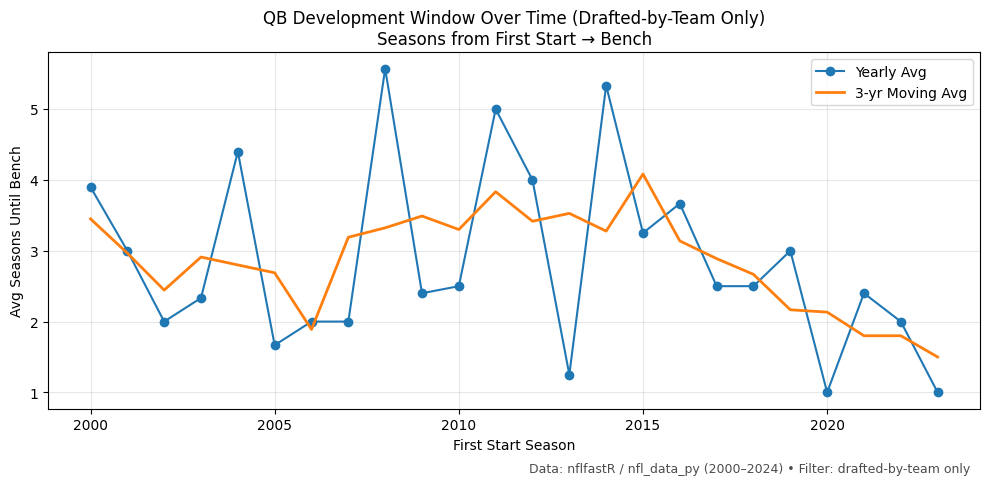

Total stints in gap_known: 276
…with known bench event:    276
Drafted-by-team stints kept: 101

Not drafted-by-team (excluded from series):
      qb_name team  first_start_season  gap_to_bench draft_team  drafted_by_team
   C.Chandler  ATL                2000           2.0        NaN            False
      T.Banks  BAL                2000           1.0        LAR            False
    R.Johnson  BUF                2000           1.0        NaN            False
  S.Beuerlein  CAR                2000           1.0        WAS            False
     C.McNown  CHI                2000           1.0        NaN            False
      A.Smith  CIN                2000           1.0         SF            False
      T.Couch  CLE                2000           3.0        NaN            False
      B.Favre   GB                2000           8.0        ATL            False
    M.Brunell  JAX                2000           2.0         GB            False
      E.Grbac   KC                2000           

In [28]:
# ===============================================================
# QB Development Window (Drafted-by-Team stints only) — Full Rewrite
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Configs / toggles
# -----------------------------
SEASON_START, SEASON_END = 2000, 2024

# If True, treat draft-day swaps as if the player were drafted by the destination team
# (e.g., Eli -> NYG, Rivers -> SD/LAC). If False, use literal drafting franchise.
TREAT_DRAFT_DAY_TRADES_AS_HOME = False

# -----------------------------
# Franchise canon mapper
# -----------------------------
FRANCHISE_CANON = {
    # Stable
    "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
    "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
    "MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO","NYG":"NYG","NYJ":"NYJ","PHI":"PHI","PIT":"PIT",
    "SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN",
    # Relocations/renames
    "SD":"LAC","LAC":"LAC",
    "STL":"LAR","LA":"LAR","LAR":"LAR",
    "OAK":"LV","LV":"LV",
    # Washington variations
    "WAS":"WAS","WSH":"WAS","WFT":"WAS","WAS ":"WAS",
}
def canon(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().upper()
    return FRANCHISE_CANON.get(s, s)

# -----------------------------
# Helpers
# -----------------------------
def ensure_bool_series(s):
    if s.dtype == "boolean":
        return s
    m = {True: True, False: False, "TRUE": True, "FALSE": False, "Yes": True, "No": False, 1: True, 0: False}
    return s.map(lambda v: m.get(v, pd.NA)).astype("boolean")

def detect_name_col(df):
    for c in ["qb_name", "player", "name"]:
        if c in df.columns:
            return c
    raise KeyError("Could not find a QB name column (looked for 'qb_name', 'player', 'name').")

def era_from_season(season):
    # tweak as you like; example 3 eras
    if season <= 2009: return "2000–2009"
    if season <= 2017: return "2010–2017"
    return "2018–2024"

# -----------------------------
# Input validation
# -----------------------------
if "gap_known" not in globals():
    raise RuntimeError("Expected a DataFrame named 'gap_known' in memory.")
if "r_pop" not in globals():
    raise RuntimeError("Expected a DataFrame named 'r_pop' in memory.")

g  = gap_known.copy()
rp = r_pop.copy()

# Detect name column(s)
G_NAME = detect_name_col(g)
R_NAME = detect_name_col(rp)

# Canonicalize teams and clamp seasons
if "team" not in g.columns:
    raise KeyError("gap_known must include a 'team' column.")
g["team"] = g["team"].map(canon)
if "team" in rp.columns:
    rp["team"] = rp["team"].map(canon)

if "first_start_season" not in g.columns:
    raise KeyError("gap_known must include 'first_start_season' (season of first start for that stint).")
if "season" in rp.columns:
    rp["season"] = rp["season"].astype(int)

# optional clamp to analysis window
g = g[(g["first_start_season"] >= SEASON_START) & (g["first_start_season"] <= SEASON_END)].copy()
if "season" in rp.columns:
    rp = rp[(rp["season"] >= SEASON_START) & (rp["season"] <= SEASON_END)].copy()

# -----------------------------
# Attach drafted_by_team to r_pop if missing
# -----------------------------
def attach_drafted_flag_to_rpop(rp: pd.DataFrame) -> pd.DataFrame:
    rp = rp.copy()
    # If already exists, coerce and return
    if "drafted_by_team" in rp.columns:
        rp["drafted_by_team"] = ensure_bool_series(rp["drafted_by_team"])
        return rp

    # If we have 'draft_team', compare to 'team'
    if "draft_team" in rp.columns and "team" in rp.columns:
        dt = rp["draft_team"].astype(str).str.strip()
        dt = dt.where(dt.notna() & (dt != "") & (dt != "nan"))
        rp["draft_team_canon"] = dt.map(lambda x: canon(x) if pd.notna(x) else np.nan)

        # Handle draft-day swaps (optional)
        if TREAT_DRAFT_DAY_TRADES_AS_HOME:
            # Known famous swap mapping by player name; extend if you care about others
            swap_to_home = {
                "Eli Manning": "NYG",
                "Philip Rivers": "LAC", "Phillip Rivers": "LAC",
            }
            # Try both full name fields if available
            candidate_names = []
            for nm in ["full_name", "player", "qb_name", "name", R_NAME]:
                if nm in rp.columns:
                    candidate_names.append(nm)
            if candidate_names:
                nm = candidate_names[0]
                rp["_swap_target"] = rp[nm].map(swap_to_home).map(canon)
                rp.loc[rp["_swap_target"].notna(), "draft_team_canon"] = rp.loc[rp["_swap_target"].notna(), "_swap_target"]
                rp.drop(columns=["_swap_target"], inplace=True, errors="ignore")

        rp["drafted_by_team"] = (rp["draft_team_canon"] == rp["team"]).astype("boolean")
        rp.drop(columns=["draft_team_canon"], inplace=True, errors="ignore")
        return rp

    # Else: cannot derive cleanly; create NA column
    rp["drafted_by_team"] = pd.Series(pd.NA, index=rp.index, dtype="boolean")
    return rp

rp = attach_drafted_flag_to_rpop(rp)

# -----------------------------
# Merge drafted flag into stints (gap_known)
# -----------------------------
# Try strict merge on (first_start_season, team, name)
keys_for_merge = [c for c in ["season","team",R_NAME,"drafted_by_team","draft_team"] if c in rp.columns]
g = g.merge(
    rp[keys_for_merge].rename(columns={"season":"first_start_season", R_NAME:G_NAME}),
    on=["first_start_season","team",G_NAME],
    how="left",
    suffixes=("","_rp")
)

# If still missing, derive via draft_team
if "drafted_by_team" not in g.columns or g["drafted_by_team"].isna().all():
    # bring draft_team if needed
    if "draft_team" not in g.columns or g["draft_team"].isna().all():
        # Build a name->draft_team mapping (mode) from rp
        if {"draft_team", R_NAME}.issubset(rp.columns):
            qd = (rp.dropna(subset=["draft_team"])
                    .assign(_dt=lambda x: x["draft_team"].astype(str).str.strip())
                    .query("_dt != '' and _dt != 'nan'")
                    .groupby(R_NAME)["_dt"]
                    .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
                    .rename("draft_team")
                    .reset_index())
            qd.rename(columns={R_NAME: G_NAME}, inplace=True)
            g = g.merge(qd, on=G_NAME, how="left")
        else:
            g["draft_team"] = np.nan

    # Canon compare
    g["draft_team_canon"] = (
        g["draft_team"].astype(str).str.strip()
           .replace({"": np.nan, "nan": np.nan})
           .map(lambda x: canon(x) if pd.notna(x) else np.nan)
    )

    if TREAT_DRAFT_DAY_TRADES_AS_HOME:
        swap_to_home = {"Eli Manning": "NYG", "Philip Rivers": "LAC", "Phillip Rivers": "LAC"}
        g["_swap_target"] = g[G_NAME].map(swap_to_home).map(canon)
        use_swap = g["_swap_target"].notna()
        g.loc[use_swap, "draft_team_canon"] = g.loc[use_swap, "_swap_target"]
        g.drop(columns=["_swap_target"], inplace=True, errors="ignore")

    g["drafted_by_team"] = (g["draft_team_canon"] == g["team"]).astype("boolean")
    g.drop(columns=["draft_team_canon"], inplace=True, errors="ignore")
else:
    g["drafted_by_team"] = ensure_bool_series(g["drafted_by_team"])

# -----------------------------
# Build robust masks and filter
# -----------------------------
# Known bench event mask (if censored_left missing, treat all as known)
if "censored_left" in g.columns:
    mask_known_bench = ~g["censored_left"].astype(bool)
else:
    mask_known_bench = pd.Series(True, index=g.index)

# Keep only drafted-by-team stints
mask_drafted = (g["drafted_by_team"] == True)
g_drafted = g.loc[mask_known_bench & mask_drafted].copy()

# -----------------------------
# Yearly series and plot
# -----------------------------
if "gap_to_bench" not in g_drafted.columns:
    raise KeyError("Expected 'gap_to_bench' (seasons from first start → bench) in gap_known.")

yearly = (
    g_drafted.groupby("first_start_season")["gap_to_bench"]
             .mean()
             .reset_index()
             .sort_values("first_start_season")
)
yearly["roll3"] = yearly["gap_to_bench"].rolling(3, center=True, min_periods=1).mean()

plt.figure(figsize=(10,5))
plt.plot(yearly["first_start_season"], yearly["gap_to_bench"], marker="o", label="Yearly Avg")
plt.plot(yearly["first_start_season"], yearly["roll3"], linewidth=2, label="3-yr Moving Avg")
plt.title("QB Development Window Over Time (Drafted-by-Team Only)\nSeasons from First Start → Bench")
plt.xlabel("First Start Season")
plt.ylabel("Avg Seasons Until Bench")
plt.grid(True, alpha=0.3)
plt.legend()
plt.text(0.99, -0.15, "Data: nflfastR / nfl_data_py (2000–2024) • Filter: drafted-by-team only",
         transform=plt.gca().transAxes, ha="right", va="top", fontsize=9, alpha=0.7)
plt.tight_layout()
plt.show()

# -----------------------------
# Diagnostics / sanity prints
# -----------------------------
print("Total stints in gap_known:", len(g))
print("…with known bench event:   ", int(mask_known_bench.sum()))
print("Drafted-by-team stints kept:", len(g_drafted))

# Who got dropped specifically for not being drafted-by-team?
name_col = G_NAME
cols = [c for c in [name_col,"team","first_start_season","bench_season","gap_to_bench","draft_team","drafted_by_team"] if c in g.columns]
excluded = g.loc[mask_known_bench & (g["drafted_by_team"] == False), cols].sort_values(["first_start_season","team"])
print("\nNot drafted-by-team (excluded from series):")
print(excluded.to_string(index=False) if not excluded.empty else "(none)")


In [ ]:
import pandas as pd

def check_primary_inclusion(gap_known: pd.DataFrame, name_substr: str):
    # Be robust to either 'qb_name' or 'player'
    name_col = "qb_name" if "qb_name" in gap_known.columns else ("player" if "player" in gap_known.columns else None)
    if name_col is None:
        raise KeyError("Expected a QB name column ('qb_name' or 'player') in gap_known.")

    cols = [c for c in [name_col, "first_start_season", "gap_to_bench", "censored_left", "bench_season"] if c in gap_known.columns]

    rows = gap_known.loc[gap_known[name_col].str.contains(name_substr, case=False, na=False), cols].copy()

    if rows.empty:
        print(f"{name_substr}: not found in gap_known (no first-start→bench record yet).")
        return

    # Determine inclusion in the plot you made (you excluded censored_left == True)
    rows["included_in_plot"] = ~rows.get("censored_left", pd.Series(False, index=rows.index)).astype(bool)

    print(rows.sort_values(["first_start_season"]).to_string(index=False))

    # Quick summary
    inc = rows["included_in_plot"].any()
    reason = "has a known bench event" if inc else "censored_left=True (no bench yet, or only injuries/IR)"
    print(f"\n→ {name_substr}: {'INCLUDED' if inc else 'EXCLUDED'} in your plotted series because {reason}.")

# Check the two you asked about
check_primary_inclusion(gap_known, "Darnold")
check_primary_inclusion(gap_known, "Richardson")


  qb_name  first_start_season  gap_to_bench  included_in_plot
S.Darnold                2018           3.0              True
S.Darnold                2021           1.0              True

→ Darnold: INCLUDED in your plotted series because has a known bench event.
Richardson: not found in gap_known (no first-start→bench record yet).


In [ ]:
from scipy import stats

# Use yearly averages (so each season is one data point)
x = yearly["first_start_season"].values
y = yearly["gap_to_bench"].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("=== Linear Trend Test ===")
print(f"Slope: {slope:.4f} seasons per year")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value (two-sided): {p_value:.4f}")

# One-sided test: H0 slope >= 0, H1 slope < 0
if slope < 0:
    p_one_sided = p_value / 2
else:
    p_one_sided = 1 - (p_value / 2)
print(f"P-value (one-sided, slope < 0): {p_one_sided:.4f}")


=== Linear Trend Test ===
Slope: -0.0487 seasons per year
R-squared: 0.248
P-value (two-sided): 0.0132
P-value (one-sided, slope < 0): 0.0066


In [ ]:
# ===== Percent drafted by team: Regular, Playoffs, Super Bowl (2000–2024) =====
import pandas as pd
import numpy as np

# --- helpers copied/assumed from your notebook ---
# canon(team), era_from_season(season), _load_first(...), build_primary_population(...)

def ensure_bool_series(s):
    if s.dtype == "boolean":
        return s
    m = {True: True, False: False, "True": True, "False": False, "Yes": True, "No": False, 1: True, 0: False}
    return s.map(m).astype("boolean")

def ensure_drafted_flag_inplace(df: pd.DataFrame, r_pop: pd.DataFrame, df_name: str) -> pd.DataFrame:
    """Ensure df has 'drafted_by_team'. Use, in order:
       (A) df.draft_team vs df.team
       (B) r_pop[['qb_name','draft_team']] merged by qb_name
       (C) set NA and warn
    """
    df = df.copy()

    # Standardize team codes
    if "team" in df.columns:
        df["team"] = df["team"].map(canon)

    # If already present, coerce to boolean and return
    if "drafted_by_team" in df.columns:
        df["drafted_by_team"] = ensure_bool_series(df["drafted_by_team"])
        return df

    # (A) If this df has draft_team, compare canon(draft_team) to team
    if "draft_team" in df.columns:
        d = df["draft_team"].astype(str).str.strip()
        d = d.where(d.notna() & (d != "") & (d != "nan"))
        df["draft_team_canon"] = d.map(lambda x: canon(x) if pd.notna(x) else np.nan)
        df["drafted_by_team"] = (df["draft_team_canon"] == df["team"]).astype("boolean")
        df.drop(columns=[c for c in ["draft_team_canon"] if c in df.columns], inplace=True, errors="ignore")
        return df

    # (B) Otherwise, try to pull draft_team by qb_name from r_pop (dedupe to a single draft_team per qb_name)
    if "qb_name" in df.columns and "draft_team" in r_pop.columns:
        # build qb_name -> draft_team mapping (prefer the most frequent non-null)
        qd = (
            r_pop.dropna(subset=["draft_team"])
                 .assign(_draft_team=lambda x: x["draft_team"].astype(str).str.strip())
                 .query("_draft_team != '' and _draft_team != 'nan'")
                 .groupby("qb_name")["_draft_team"]
                 .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
                 .rename("draft_team")
                 .reset_index()
        )
        qd["draft_team"] = qd["draft_team"].map(canon)

        df = df.merge(qd, on="qb_name", how="left")
        if "draft_team" in df.columns:
            df["drafted_by_team"] = (df["draft_team"] == df["team"]).astype("boolean")
            return df

    # (C) Give up gracefully
    df["drafted_by_team"] = pd.array([pd.NA]*len(df), dtype="boolean")
    print(f"[warn] {df_name}: could not derive drafted_by_team (no draft_team and no qb_name match in r_pop).")
    return df

def pct_boolean(x: pd.Series) -> float:
    x = ensure_bool_series(x) if x.dtype != "boolean" else x
    return float(x.dropna().mean()) if x.notna().any() else np.nan

# ---- Load canonical population and ensure drafted flag there too ----
SEASON_START, SEASON_END = 2000, 2024
REG_CANDIDATES = [
    "qb_primary_starters_2000_2024.csv"
]

r_pop = build_primary_population(SEASON_START, SEASON_END, REG_CANDIDATES)
# Try to create drafted_by_team in r_pop if missing
if "drafted_by_team" not in r_pop.columns:
    if "draft_team" in r_pop.columns:
        r_pop = ensure_drafted_flag_inplace(r_pop, r_pop, "REG_POP")
    else:
        r_pop["drafted_by_team"] = pd.array([pd.NA]*len(r_pop), dtype="boolean")
        print("[warn] REG_POP: r_pop has no draft_team; drafted_by_team will be NA unless attached later by qb_name.")

# ---------- Regular-season primaries ----------
reg_overall = pct_boolean(r_pop["drafted_by_team"])
print(f"Regular-season primary QBs drafted by their team (2000–2024): {reg_overall:.1%}")

era_reg = (
    r_pop.assign(era=r_pop["season"].map(era_from_season))
         .groupby("era")["drafted_by_team"].apply(pct_boolean)
         .reset_index(name="pct_drafted")
)
print("\nBy era (regular-season primaries):")
print(era_reg.to_string(index=False))

# ---------- Playoff starters ----------
PO_CANDIDATES = ["qb_playoff_first_starters_2000_2024.csv"]
po = _load_first("po_m", PO_CANDIDATES)
po = po.query("@SEASON_START <= season <= @SEASON_END").copy()
po["team"] = po["team"].map(canon)

# Prefer per-QB derivation; if merge works, fine; if not, fallback will still attach
try:
    po = po.merge(r_pop[["season","team","qb_name","drafted_by_team"]], on=["season","team","qb_name"],
                  how="left", validate="m:1")
except Exception:
    pass

po = ensure_drafted_flag_inplace(po, r_pop, "PLAYOFFS")

po_overall = pct_boolean(po["drafted_by_team"])
print(f"\nPlayoff starting QBs drafted by their team (2000–2024): {po_overall:.1%}")

era_po = (
    po.assign(era=po["season"].map(era_from_season))
      .groupby("era")["drafted_by_team"].apply(pct_boolean)
      .reset_index(name="pct_drafted")
)
print("\nBy era (playoff starters):")
print(era_po.to_string(index=False))

# ---------- Super Bowl starters ----------
SB_CANDIDATES = ["qb_super_bowl_starters_2000_2024.csv"]
sb = _load_first("sb_m", SB_CANDIDATES)
sb = sb.query("@SEASON_START <= season <= @SEASON_END").copy()
sb["team"] = sb["team"].map(canon)

try:
    sb = sb.merge(r_pop[["season","team","qb_name","drafted_by_team"]], on=["season","team","qb_name"],
                  how="left", validate="m:1")
except Exception:
    pass

sb = ensure_drafted_flag_inplace(sb, r_pop, "SUPER_BOWL")

sb_overall = pct_boolean(sb["drafted_by_team"])
print(f"\nSuper Bowl starting QBs drafted by their team (2000–2024): {sb_overall:.1%}")

era_sb = (
    sb.assign(era=sb["season"].map(era_from_season))
      .groupby("era")["drafted_by_team"].apply(pct_boolean)
      .reset_index(name="pct_drafted")
)
print("\nBy era (Super Bowl starters):")
print(era_sb.to_string(index=False))

# ---- Quick NA diagnostics so you can fix name mismatches if needed ----
for tag, df in [("REG", r_pop), ("PO", po), ("SB", sb)]:
    na_ct = df["drafted_by_team"].isna().sum()
    if na_ct:
        print(f"\n[warn] {tag}: {na_ct}/{len(df)} rows have NA drafted_by_team (likely missing draft_team and no qb_name match).")
        # Optional peek at the first few NAs to fix names manually
        peek = df.loc[df["drafted_by_team"].isna(), ["season","team","qb_name"]].head(10)
        print(peek.to_string(index=False))


Regular-season primary QBs drafted by their team (2000–2024): 52.6%

By era (regular-season primaries):
  era  pct_drafted
2000s     0.430818
2010s     0.571875
2020s     0.625000

Playoff starting QBs drafted by their team (2000–2024): 59.0%

By era (playoff starters):
  era  pct_drafted
2000s     0.433333
2010s     0.691667
2020s     0.685714

Super Bowl starting QBs drafted by their team (2000–2024): 68.0%

By era (Super Bowl starters):
  era  pct_drafted
2000s          0.5
2010s          0.8
2020s          0.8


=== Per-Year Summary (team-season denominator) ===


,season,pct_drafted_regular,po_rate_acquired,po_rate_drafted,sb_rate_acquired,sb_rate_drafted
0,2000,32.26,28.57,60.00,9.52,0.00
1,2001,32.26,47.62,20.00,4.76,10.00
2,2002,37.50,35.00,41.67,10.00,0.00
3,2003,28.12,30.43,55.56,4.35,11.11
4,2004,50.00,25.00,50.00,0.00,12.50
5,2005,50.00,31.25,43.75,6.25,6.25
6,2006,50.00,43.75,31.25,0.00,12.50
7,2007,46.88,35.29,40.00,5.88,6.67
8,2008,46.88,41.18,33.33,5.88,6.67
9,2009,56.25,35.71,38.89,7.14,5.56


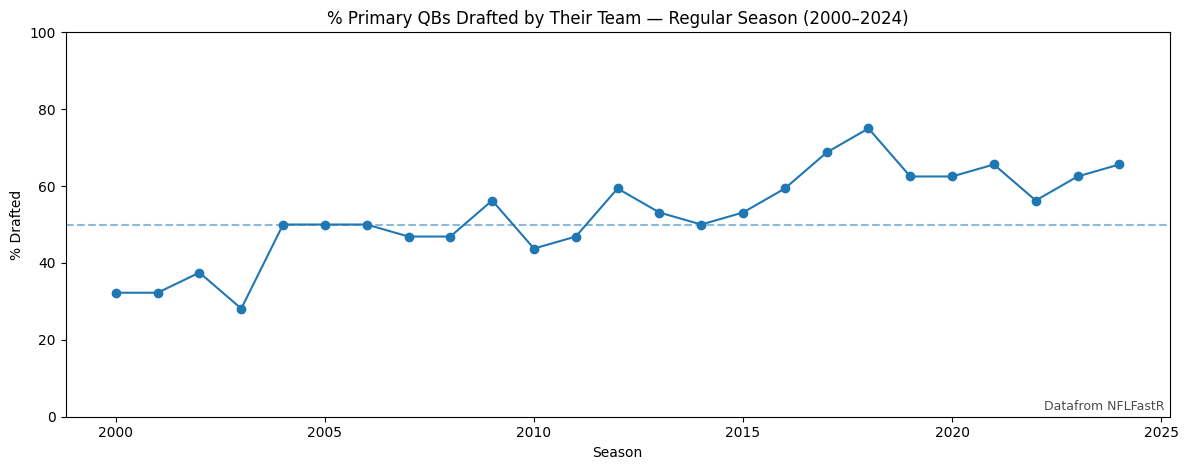

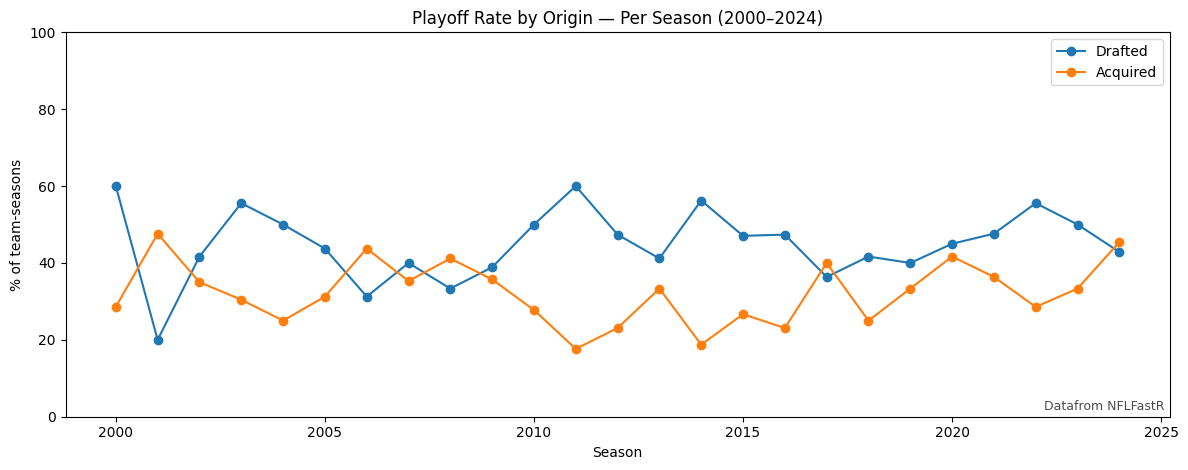

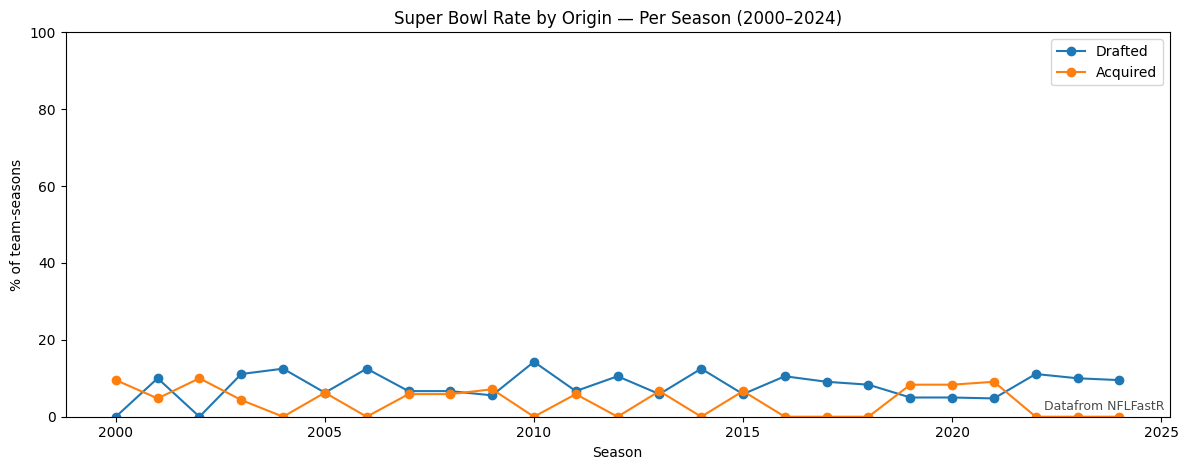

In [ ]:
# ================================
# Per-Year Stats & Time-Series Plots
# ================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import sqrt
import os, time

# ---------- Reuse knobs/helpers if present; else define light fallbacks ----------
try:
    SEASON_START
except NameError:
    SEASON_START, SEASON_END = 2000, 2024

try:
    REG_CANDS
except NameError:
    REG_CANDS = ["qb_primary_starters_1999_2024.csv","qb_primary_starters_2000_2024.csv"]
    PO_CANDS  = ["qb_playoff_first_starters_1999_2024.csv","qb_playoff_first_starters_2000_2024.csv"]
    SB_CANDS  = ["qb_super_bowl_starters_1999_2024.csv","qb_super_bowl_starters_2000_2024.csv"]

try:
    DATA_SOURCE
except NameError:
    DATA_SOURCE = "Data: qb_primary_starters_*.csv; qb_playoff_first_starters_*.csv; qb_super_bowl_starters_*.csv"

def annotate_source(ax, text=DATA_SOURCE):
    ax.text(0.995, 0.01, text, transform=ax.transAxes, ha="right", va="bottom", fontsize=9, alpha=0.7)

try:
    canon_team
except NameError:
    FRANCHISE_CANON = {
        "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
        "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
        "LAC":"LAC","LAR":"LAR","LV":"LV","MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO",
        "NYG":"NYG","NYJ":"NYJ","PHI":"PHI","PIT":"PIT","SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN","WAS":"WAS",
        "OAK":"LV","RAI":"LV","SD":"LAC","SDG":"LAC","STL":"LAR","LA":"LAR","PHO":"ARI","WSH":"WAS",
        "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
    }
    def canon_team(x):
        if pd.isna(x): return np.nan
        s = str(x).upper().strip()
        return FRANCHISE_CANON.get(s, s)

try:
    _load_first
except NameError:
    def _load_first(name_in_mem, candidates, force_reload=False, verbose=False):
        if (not force_reload) and name_in_mem in globals():
            return globals()[name_in_mem].copy()
        for p in candidates:
            try:
                df = pd.read_csv(p)
                globals()[name_in_mem] = df.copy()
                return df
            except FileNotFoundError:
                continue
        raise FileNotFoundError(f"Couldn’t find any of: {candidates}")

def ensure_bool_series(s):
    if s.dtype == "boolean": return s
    m = {True: True, False: False, "True": True, "False": False, "Yes": True, "No": False, 1: True, 0: False}
    return s.map(m).astype("boolean")

def ensure_drafted_flag_inplace(df: pd.DataFrame, fallback_pop: pd.DataFrame, df_name: str, recompute=True) -> pd.DataFrame:
    df = df.copy()
    if "team" in df.columns: df["team"] = df["team"].map(canon_team)
    if (not recompute) and ("drafted_by_team" in df.columns):
        df["drafted_by_team"] = ensure_bool_series(df["drafted_by_team"]); return df
    if "draft_team" in df.columns:
        d = df["draft_team"].astype(str).str.strip()
        d = d.where(d.notna() & (d != "") & (d.str.lower() != "nan"))
        df["draft_team_canon"] = d.map(lambda x: canon_team(x) if pd.notna(x) else np.nan)
        df["drafted_by_team"] = (df["draft_team_canon"] == df["team"]).astype("boolean")
        df.drop(columns=[c for c in ["draft_team_canon"] if c in df.columns], inplace=True, errors="ignore")
        return df
    if ("qb_name" in df.columns) and ("draft_team" in fallback_pop.columns):
        qd = (fallback_pop.dropna(subset=["draft_team"])
                          .assign(_draft_team=lambda x: x["draft_team"].astype(str).str.strip())
                          .query("_draft_team != '' and _draft_team.str.lower() != 'nan'")
                          .groupby("qb_name")["_draft_team"]
                          .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
                          .rename("draft_team").reset_index())
        qd["draft_team"] = qd["draft_team"].map(canon_team)
        df = df.merge(qd, on="qb_name", how="left")
        if "draft_team" in df.columns:
            df["drafted_by_team"] = (df["draft_team"] == df["team"]).astype("boolean")
            return df
    df["drafted_by_team"] = pd.array([pd.NA]*len(df), dtype="boolean"); return df

def wilson_ci(successes, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    p = successes/n; denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    margin = (z * np.sqrt((p*(1-p)/n) + (z*z/(4*n*n)))) / denom
    return (center - margin, center + margin)

# ---------- Build base frames (force_reload recommended if you just edited CSVs) ----------

reg = reg.query("@SEASON_START <= season <= @SEASON_END").copy()
po  =  po.query("@SEASON_START <= season <= @SEASON_END").copy()
sb  =  sb.query("@SEASON_START <= season <= @SEASON_END").copy()

for df in (reg, po, sb):
    if "team" in df.columns:
        df["team"] = df["team"].map(canon_team)

# Regular-season with drafted flag; keep only known
reg_k = ensure_drafted_flag_inplace(reg, reg, "REGULAR", recompute=True)
reg_k = reg_k[reg_k["drafted_by_team"].notna()].copy()

# TEAM-SEASON denominator (collapse to one row per season,team) using simple deterministic tie-break:
# if you have starts columns in your env script, you can paste your smarter collapse function here.
den = (reg_k.sort_values(["season","team","qb_name"])
              .drop_duplicates(subset=["season","team"], keep="last")
              [["season","team","drafted_by_team"]]
              .reset_index(drop=True))

# Playoff/SB membership sets (full tables, no draft filter)
po_set = set(map(tuple, po[["season","team"]].drop_duplicates().values))
sb_set = set(map(tuple, sb[["season","team"]].drop_duplicates().values))
den["made_playoffs"] = list(map(lambda x: x in po_set, map(tuple, den[["season","team"]].values)))
den["made_sb"]       = list(map(lambda x: x in sb_set, map(tuple, den[["season","team"]].values)))

# ---------- Per-year regular share: % of primary QBs drafted (by team-season) ----------
reg_year = (den.groupby("season")["drafted_by_team"]
              .agg(lambda s: 100 * s.mean())
              .rename("pct_drafted_regular")
              .reset_index())

# ---------- Per-year Playoff & SB rates by origin (team-season denominator) ----------
per_year = (den.groupby(["season","drafted_by_team"])
              .agg(n=("team","count"),
                   po=("made_playoffs","sum"),
                   sb=("made_sb","sum"))
              .reset_index())

# Rates + CIs per season/origin
per_year["po_rate"] = 100 * per_year["po"] / per_year["n"]
per_year["sb_rate"] = 100 * per_year["sb"] / per_year["n"]
per_year[["po_ci_lo","po_ci_hi"]] = per_year.apply(
    lambda r: pd.Series(np.array(wilson_ci(r["po"], r["n"])) * 100), axis=1)
per_year[["sb_ci_lo","sb_ci_hi"]] = per_year.apply(
    lambda r: pd.Series(np.array(wilson_ci(r["sb"], r["n"])) * 100), axis=1)

# Friendly labels
per_year["QB Origin"] = per_year["drafted_by_team"].map({True:"Drafted", False:"Acquired"})
per_year = per_year.drop(columns=["drafted_by_team"])

# Wide convenience tables (one row per season)
po_wide = per_year.pivot(index="season", columns="QB Origin", values="po_rate").rename(
    columns={"Drafted":"po_rate_drafted","Acquired":"po_rate_acquired"}).reset_index()
sb_wide = per_year.pivot(index="season", columns="QB Origin", values="sb_rate").rename(
    columns={"Drafted":"sb_rate_drafted","Acquired":"sb_rate_acquired"}).reset_index()

yearly_summary = (reg_year.merge(po_wide, on="season", how="left")
                           .merge(sb_wide, on="season", how="left")
                           .sort_values("season"))

print("=== Per-Year Summary (team-season denominator) ===")
display(yearly_summary.round(2).fillna(""))

# ---------- Plots ----------
# 1) Regular share drafted by season
plt.figure(figsize=(12,4.8))
ax = plt.gca()
plt.plot(reg_year["season"], reg_year["pct_drafted_regular"], marker="o")
plt.axhline(50, linestyle="--", alpha=0.5)
plt.ylim(0,100)
plt.title(f"% Primary QBs Drafted by Their Team — Regular Season ({SEASON_START}–{SEASON_END})")
plt.xlabel("Season"); plt.ylabel("% Drafted")
plt.tight_layout(); annotate_source(ax); plt.show()

# 2) Playoff rate by season & origin (two lines)
plot_df = per_year.pivot(index="season", columns="QB Origin", values="po_rate").sort_index()
plt.figure(figsize=(12,4.8))
ax = plt.gca()
if "Drafted" in plot_df.columns:
    plt.plot(plot_df.index, plot_df["Drafted"], marker="o", label="Drafted")
if "Acquired" in plot_df.columns:
    plt.plot(plot_df.index, plot_df["Acquired"], marker="o", label="Acquired")
plt.ylim(0,100)
plt.title(f"Playoff Rate by Origin — Per Season ({SEASON_START}–{SEASON_END})")
plt.xlabel("Season"); plt.ylabel("% of team-seasons")
plt.legend(); plt.tight_layout(); annotate_source(ax); plt.show()

# 3) Super Bowl rate by season & origin (two lines)
plot_df = per_year.pivot(index="season", columns="QB Origin", values="sb_rate").sort_index()
plt.figure(figsize=(12,4.8))
ax = plt.gca()
if "Drafted" in plot_df.columns:
    plt.plot(plot_df.index, plot_df["Drafted"], marker="o", label="Drafted")
if "Acquired" in plot_df.columns:
    plt.plot(plot_df.index, plot_df["Acquired"], marker="o", label="Acquired")
plt.ylim(0,100)
plt.title(f"Super Bowl Rate by Origin — Per Season ({SEASON_START}–{SEASON_END})")
plt.xlabel("Season"); plt.ylabel("% of team-seasons")
plt.legend(); plt.tight_layout(); annotate_source(ax); plt.show()

# (Optional) quick NA diagnostics for the seasons where something looks odd
na_counts = den.assign(is_na=den["drafted_by_team"].isna()).groupby("season")["is_na"].sum()
if int(na_counts.sum()) > 0:
    print("\n[warn] Some seasons have NA drafted_by_team in the denominator:")
    print(na_counts[na_counts>0])


In [ ]:
import pandas as pd
import numpy as np

# Load primary starters
reg = pd.read_csv("qb_primary_starters_2000_2024.csv")

# Standardize team codes if needed
FRANCHISE_CANON = {
    "OAK":"LV","RAI":"LV","SD":"LAC","SDG":"LAC","STL":"LAR","LA":"LAR","PHO":"ARI","WSH":"WAS",
    "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
}
def canon(t):
    if pd.isna(t): return np.nan
    return FRANCHISE_CANON.get(str(t).upper(), str(t).upper())

reg["team"]       = reg["team"].map(canon)
reg["draft_team"] = reg["draft_team"].map(canon)

# Keep only seasons since 2000
reg = reg.query("season >= 2000").copy()

# Flag drafted_by_team
reg["drafted_by_team"] = (reg["draft_team"] == reg["team"])

# Overall %
pct = reg["drafted_by_team"].mean() * 100
print(f"Since 2000, {pct:.1f}% of primary starting QBs were drafted by their own team.")


Since 2000, 52.6% of primary starting QBs were drafted by their own team.


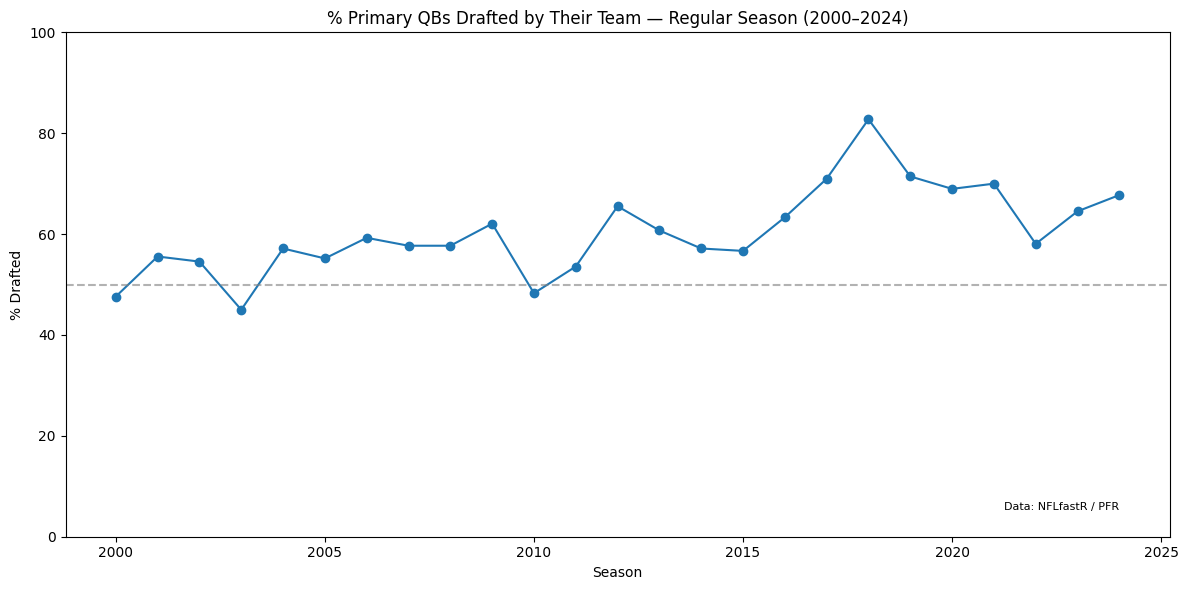

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load starters (already canonized if needed)
reg = pd.read_csv("qb_primary_starters_2000_2024.csv")

# Ensure draft_team info is standardized
FRANCHISE_CANON = {
    "OAK":"LV","RAI":"LV","SD":"LAC","SDG":"LAC","STL":"LAR","LA":"LAR","PHO":"ARI","WSH":"WAS",
    "GNB":"GB","NWE":"NE","NOR":"NO","SFO":"SF",
}
def canon(t):
    if pd.isna(t): return pd.NA
    return FRANCHISE_CANON.get(str(t).upper(), str(t).upper())

reg["team"]       = reg["team"].map(canon)
reg["draft_team"] = reg["draft_team"].map(canon)

# Exclude rows with missing draft_team (NaN)
reg_known = reg[reg["draft_team"].notna()].copy()

# Flag drafted_by_team
reg_known["drafted_by_team"] = (reg_known["draft_team"] == reg_known["team"])

# Compute share by year
yearly = (
    reg_known.groupby("season")["drafted_by_team"]
             .mean()
             .mul(100)
)

# Plot
plt.figure(figsize=(12,6))
plt.plot(yearly.index, yearly.values, marker="o")
plt.axhline(50, linestyle="--", alpha=0.6, color="gray")
plt.ylim(0,100)
plt.title("% Primary QBs Drafted by Their Team — Regular Season (2000–2024)")
plt.xlabel("Season"); plt.ylabel("% Drafted")
plt.text(yearly.index.max(), 5, "Data: NFLfastR / PFR", ha="right", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

YEAR = 2018  # <- change to inspect other seasons

# 1) Who’s in your 2018 denominator (row-weighted, i.e., every row in reg_known)?
yr = (reg_known.loc[reg_known["season"] == YEAR,
                    ["season","team","qb_name","draft_team","drafted_by_team"]]
                .sort_values(["team","qb_name"])
                .reset_index(drop=True))
print(f"=== Row-weighted denominator: {YEAR} ({len(yr)} rows) ===")
display(yr)

# 2) Quick counts for 2018 (row-weighted)
counts = (yr["drafted_by_team"]
          .value_counts(dropna=False)
          .rename(index={True:"Drafted", False:"Acquired", pd.NA:"NA"})
          .rename("rows"))
counts["Total"] = counts.sum()
print("\nRow-weighted counts:")
display(counts.to_frame())

pct_row = 100 * (yr["drafted_by_team"].mean())
print(f"Row-weighted % drafted in {YEAR}: {pct_row:.1f}%")

# 3) Check if you have multiple 'primary' rows for the same team in 2018
dups = (yr.groupby("team")["qb_name"].nunique()
          .rename("qb_rows")
          .reset_index()
          .query("qb_rows > 1"))
if not dups.empty:
    print("\n[Note] Multiple primary rows for some teams in", YEAR)
    display(dups.sort_values("team"))
    # show those teams’ rows
    multi_teams = dups["team"].tolist()
    display(yr[yr["team"].isin(multi_teams)].sort_values(["team","qb_name"]))

# 4) Team-season view (collapse to one row per team) so you can see which QB is being chosen
#    Tie-break: if you have 'games_started' or 'starts', this will prefer the most.
tie_cols = [c for c in ["games_started","starts","gs","n_games"] if c in reg_known.columns]
ascending = [False]*len(tie_cols)  # DESC for counts
sort_cols = tie_cols + ["qb_name"] # final deterministic tie-break on name

yr_team = (yr.sort_values(sort_cols, ascending=ascending+[True])
             .drop_duplicates(subset=["team"], keep="first")
             .sort_values("team")
             .reset_index(drop=True))

print(f"\n=== Team-season denominator (one per team): {YEAR} ({len(yr_team)} teams) ===")
display(yr_team[["team","qb_name","draft_team","drafted_by_team"]])

pct_team = 100 * yr_team["drafted_by_team"].mean()
print(f"Team-season % drafted in {YEAR}: {pct_team:.1f}%")


=== Row-weighted denominator: 2018 (29 rows) ===


,season,team,qb_name,draft_team,drafted_by_team
0,2018,ARI,J.Rosen,ARI,True
1,2018,ATL,M.Ryan,ATL,True
2,2018,BAL,J.Flacco,BAL,True
3,2018,BUF,J.Allen,BUF,True
4,2018,CAR,C.Newton,CAR,True
5,2018,CHI,M.Trubisky,CHI,True
6,2018,CIN,A.Dalton,CIN,True
7,2018,CLE,B.Mayfield,CLE,True
8,2018,DAL,D.Prescott,DAL,True
9,2018,DET,M.Stafford,DET,True



Row-weighted counts:


,rows
drafted_by_team,
Drafted,24
Acquired,5
Total,29


Row-weighted % drafted in 2018: 82.8%


KeyError: 'starts'

In [ ]:
# ===== Sanity checks & lookups =====

# 1) Confirm the dataset has exactly one primary QB per team per season
def sanity_check_primary(df):
    # one row per (season, team)
    dup = df.duplicated(subset=["season","team"], keep=False)
    if dup.any():
        print("[FAIL] Duplicate (season,team) rows found:")
        display(df.loc[dup, ["season","team","qb_name"]].sort_values(["season","team"]))
    else:
        print("[OK] No duplicates by (season, team).")
    # should be 32 teams each season
    per_season = df.groupby("season")["team"].nunique().sort_index()
    print("\nTeams per season:")
    print(per_season.to_string())
    bad = per_season[per_season != 32]
    if not bad.empty:
        print("\n[WARN] These seasons do not have 32 teams:")
        print(bad)

sanity_check_primary(r_pop)

# 2) List the primary QBs for a given season (useful to show your friend)
def primary_qbs_for_season(df, season):
    cols = [c for c in ["season","team","qb_name","draft_team","drafted_by_team","starts"] if c in df.columns]
    out = (df.query("season == @season")[cols]
             .sort_values(["team"]).reset_index(drop=True))
    return out

display(primary_qbs_for_season(r_pop, 2018))  # <- 2018 example

# 3) Does a specific player appear as a primary, and when/for whom?
def where_is_player_primary(df, name_substr):
    mask = df["qb_name"].str.contains(name_substr, case=False, na=False)
    cols = [c for c in ["season","team","qb_name","starts","draft_team","drafted_by_team"] if c in df.columns]
    out = df.loc[mask, cols].sort_values(["season","team"]).reset_index(drop=True)
    return out

# Examples you asked about:
print("\nSam Darnold primary seasons:")
display(where_is_player_primary(r_pop, "Darnold"))

print("\nAnthony Richardson primary seasons:")
display(where_is_player_primary(r_pop, "Richardson"))

# 4) Spot-check drafted flag for a player in a season (e.g., the “is he drafted by current team?” bit)
def drafted_flag(df, season, name_substr):
    rows = df[df["season"].eq(season) & df["qb_name"].str.contains(name_substr, case=False, na=False)]
    cols = [c for c in ["season","team","qb_name","draft_team","drafted_by_team"] if c in df.columns]
    return rows[cols]

print("\nDrafted flag – Darnold 2018:")
display(drafted_flag(r_pop, 2018, "Darnold"))

print("\nDrafted flag – Richardson (current season):")
display(drafted_flag(r_pop, r_pop["season"].max(), "Richardson"))

# 5) Quick NA audit (name mismatches or missing draft_team)
def drafted_na_audit(df):
    na = df[df["drafted_by_team"].isna()]
    if na.empty:
        print("[OK] No NA drafted_by_team rows.")
        return
    print(f"[WARN] {len(na)} rows missing drafted_by_team. First few:")
    display(na[["season","team","qb_name","draft_team"]].head(15))

drafted_na_audit(r_pop)


[OK] No duplicates by (season, team).

Teams per season:
season
2000    31
2001    31
2002    32
2003    32
2004    32
2005    32
2006    32
2007    32
2008    32
2009    32
2010    32
2011    32
2012    32
2013    32
2014    32
2015    32
2016    32
2017    32
2018    32
2019    32
2020    32
2021    32
2022    32
2023    32
2024    32

[WARN] These seasons do not have 32 teams:
season
2000    31
2001    31
Name: team, dtype: int64


,season,team,qb_name,draft_team,drafted_by_team
0,2018,ARI,J.Rosen,ARI,True
1,2018,ATL,M.Ryan,ATL,True
2,2018,BAL,J.Flacco,BAL,True
3,2018,BUF,J.Allen,BUF,True
4,2018,CAR,C.Newton,CAR,True
5,2018,CHI,M.Trubisky,CHI,True
6,2018,CIN,A.Dalton,CIN,True
7,2018,CLE,B.Mayfield,CLE,True
8,2018,DAL,D.Prescott,DAL,True
9,2018,DEN,C.Keenum,NaN,False



Sam Darnold primary seasons:


,season,team,qb_name,draft_team,drafted_by_team
0,2018,NYJ,S.Darnold,NaN,False
1,2019,NYJ,S.Darnold,NaN,False
2,2020,NYJ,S.Darnold,NaN,False
3,2021,CAR,S.Darnold,NaN,False
4,2024,MIN,S.Darnold,NaN,False



Anthony Richardson primary seasons:


,season,team,qb_name,draft_team,drafted_by_team
0,2024,IND,A.Richardson,IND,True



Drafted flag – Darnold 2018:


,season,team,qb_name,draft_team,drafted_by_team
598,2018,NYJ,S.Darnold,NaN,False



Drafted flag – Richardson (current season):


,season,team,qb_name,draft_team,drafted_by_team
779,2024,IND,A.Richardson,IND,True


[OK] No NA drafted_by_team rows.
